In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import shutil
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random

import cv2
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import Xception, ResNet50, MobileNet, VGG16  # Import ResNet50, MobileNet, VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, MaxPooling2D, Flatten #Import layers you are using
from tensorflow.keras.models import Model # Keep Model import if you use it directly
from tensorflow.keras import models # ADD THIS LINE: Import the 'models' module
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve,auc
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import plot_model

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
EPOCHS = 10      # Reduced epochs for faster training (try even less initially)
BATCH_SIZE = 32    # Increased batch size (adjust based on GPU memory)
IMAGE_SIZE = (256, 256) # Reduced image size for faster processing
SAMPLE_SIZE_PERCENT = None  # Set to None to use full dataset, or a float (e.g., 0.01) for sample - OPTION ADDED HERE


In [4]:
# Define base directory and target split ratios
base_dir = 'd:/deepfake/Celeb-DF-New'
output_dir = 'd:/deepfake/split_data1'
split_ratios = {'train': 0.5, 'valid': 0.2, 'test': 0.3}

# Create output directories
for split in split_ratios.keys():
    for label in ['Real', 'Fake']:
        Path(f"{output_dir}/{split}/{label}").mkdir(parents=True, exist_ok=True)

# Function to split and copy images
def split_images(label, label_dir):
    # Get all images in the label directory
    images = os.listdir(label_dir)
    random.shuffle(images)  # Shuffle images

    # Calculate split sizes
    total_images = len(images)
    train_size = int(split_ratios['train'] * total_images)
    valid_size = int(split_ratios['valid'] * total_images)

    # Split images
    train_images = images[:train_size]
    valid_images = images[train_size:train_size + valid_size]
    test_images = images[train_size + valid_size:]

    # Function to copy files to output directory
    def copy_images(image_list, split):
        for img_file in image_list:
            src = os.path.join(label_dir, img_file)
            dest = os.path.join(output_dir, split, label, img_file)
            shutil.copy(src, dest)

    # Copy images to respective directories
    copy_images(train_images, 'train')
    copy_images(valid_images, 'valid')
    copy_images(test_images, 'test')
    

# Split and copy images for both labels
for label in ['Real', 'Fake']:
    label_dir = os.path.join(base_dir, label)
    split_images(label, label_dir)

print("Images have been split and saved to:", output_dir)

KeyboardInterrupt: 

In [24]:
main_path = 'd:/deepfake//real_vs_fake/real-vs-fake'
second_main_path = 'd:/deepfake/Dataset'
third_main_path = 'd:/deepfake/split_data1'  # Celeb-DF-New after splitting

# Standardized subdirectory names for datasets
sub_dirs_mapping = {
    'train': ['train', 'Train', 'train'],  # Train for Deepfake, train for others
    'valid': ['valid', 'Validation', 'valid'],  # Validation for Deepfake, valid for others
    'test': ['test', 'Test', 'test']  # Test for Deepfake, test for others
}

# Label mapping for real and fake folders
label_mapping = {'Real': 1, 'Fake': 0, 'real': 1, 'fake': 0}

In [25]:
def create_dataframe(base_path, sub_dir, label_map, sample_percent=None): # sample_percent defaults to None
    data = {"file_path": [], "label": []}
    for label_dir, label in label_map.items():  # Iterate over 'Real' and 'Fake'
        folder_path = os.path.join(base_path, sub_dir, label_dir)
        if os.path.exists(folder_path):  # Ensure the folder exists
            img_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))] # Get image files
            if sample_percent is not None and 0 < sample_percent < 1.0: # Sample only if sample_percent is a float between 0 and 1
                sample_size = int(len(img_files) * sample_percent)
                img_files = random.sample(img_files, sample_size) # Randomly sample
            for img_file in img_files:
                data["file_path"].append(os.path.join(folder_path, img_file))
                data["label"].append(label)
    return pd.DataFrame(data)

In [26]:

# Function to create dataframes for each dataset separately and combined
def create_dataframes(sample_percent): # Pass sample_percent here
    dataframes = {}
    # Combined Dataframes (as before)
    for split_key, sub_dirs in sub_dirs_mapping.items():
        combined_data = pd.DataFrame()
        df_140k = create_dataframe(main_path, sub_dirs[0], label_mapping, sample_percent) # Pass sample_percent
        combined_data = pd.concat([combined_data, df_140k], ignore_index=True)
        df_deepfake = create_dataframe(second_main_path, sub_dirs[1], label_mapping, sample_percent) # Pass sample_percent
        combined_data = pd.concat([combined_data, df_deepfake], ignore_index=True)
        df_celeb = create_dataframe(third_main_path, sub_dirs[2], label_mapping, sample_percent) # Pass sample_percent
        combined_data = pd.concat([combined_data, df_celeb], ignore_index=True)
        dataframes[f'combined_{split_key}'] = combined_data

    # Separate Dataframes
    for split_key, sub_dirs in sub_dirs_mapping.items():
        dataframes[f'140k_{split_key}'] = create_dataframe(main_path, sub_dirs[0], label_mapping, sample_percent) # Pass sample_percent
        dataframes[f'deepfake_{split_key}'] = create_dataframe(second_main_path, sub_dirs[1], label_mapping, sample_percent) # Pass sample_percent
        dataframes[f'celebdf_{split_key}'] = create_dataframe(third_main_path, sub_dirs[2], label_mapping, sample_percent) # Pass sample_percent
    return dataframes

dataframes = create_dataframes(SAMPLE_SIZE_PERCENT)

In [27]:
def create_generators(train_df, valid_df, test_df):
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        horizontal_flip = True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2
    )
    datagen = ImageDataGenerator(rescale=1.0/255)

    # Training generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='file_path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )

    # Validation generator
    valid_generator = datagen.flow_from_dataframe(
        dataframe=valid_df,
        x_col='file_path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )

    # Test generator
    test_generator = datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='file_path',
        y_col='label',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    return train_generator, valid_generator, test_generator

In [9]:
def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [10]:
def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def create_mobilenet_model():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    base_model.trainable = False
    mobile_model = models.Sequential()
    mobile_model.add(base_model)
    mobile_model.add(layers.GlobalAveragePooling2D())
    mobile_model.add(layers.Dense(128, activation='relu'))
    mobile_model.add(layers.Dropout(0.5))
    mobile_model.add(layers.Dense(1, activation='sigmoid'))
    return mobile_model

def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [11]:
def train_and_evaluate(train_generator, valid_generator, test_generator, dataset_name, model, model_name):
    model.compile(optimizer='adam', # You can adjust optimizer as needed
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]) # Added AUC metric

    checkpoint_path = f"best_model11_{model_name}_{dataset_name}.h5"
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0) # Reduced verbosity
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0) # Reduced verbosity

    history = model.fit(
        train_generator,
        validation_data=valid_generator, # Use validation_data instead of separate steps
        epochs=EPOCHS,
        callbacks=[early_stopping, checkpoint],
        verbose=1 # Keep verbosity for training progress
    )

    model.load_weights(checkpoint_path) # Load best weights

    # --- Evaluation on Test Set ---
    print(f"\n--- {dataset_name.upper()} Dataset - {model_name.upper()} - Test Set Evaluation ---")
    test_loss, test_accuracy, test_auc = model.evaluate(test_generator, verbose=0)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%, Test AUC: {test_auc:.4f}')

    # --- Predictions for Confusion Matrix and ROC Curve ---
    y_pred_prob = model.predict(test_generator, verbose=0)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    y_test = test_generator.classes

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_binary)
    print(f"\n{dataset_name.upper()} Dataset - {model_name.upper()} - Confusion Matrix:")
    print(cm)

    # --- Classification Report ---
    print(f"\n{dataset_name.upper()} Dataset - {model_name.upper()} - Classification Report:")
    print(classification_report(y_test, y_pred_binary, target_names=['Fake', 'Real'])) # Added target names

    # --- ROC Curve ---
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # --- Plotting ---
    plt.figure(figsize=(20, 10)) # Increased figure size for more plots

    # Accuracy and Loss Curves
    plt.subplot(2, 2, 1) # 2 rows, 2 columns, plot 1
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{dataset_name.upper()} - {model_name.upper()} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(2, 2, 2) # 2 rows, 2 columns, plot 2
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{dataset_name.upper()} - {model_name.upper()} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # ROC Curve
    plt.subplot(2, 2, 3) # 2 rows, 2 columns, plot 3
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name.upper()} - {model_name.upper()} - ROC Curve')
    plt.legend(loc="lower right")

    # Confusion Matrix
    plt.subplot(2, 2, 4) # 2 rows, 2 columns, plot 4
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(f'{dataset_name.upper()} - {model_name.upper()} - Confusion Matrix')

    plt.tight_layout()
    plt.show()

    model_save_path = f"{model_name}_{dataset_name}.h5" # Define the save path variable
    model.save(model_save_path)
    print(f"Model '{model_name.upper()}' for dataset '{dataset_name.upper()}' saved at: {model_save_path}") # Print save path

In [12]:
from tensorflow.keras import Sequential, layers 
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


Training and Evaluating on COMBINED Dataset
Found 237656 validated image filenames belonging to 2 classes.
Found 55334 validated image filenames belonging to 2 classes.
Found 62386 validated image filenames belonging to 2 classes.

--- Training CNN model on COMBINED dataset ---
Epoch 1/10
7427/7427 [==============================] - 10299s 1s/step - loss: 0.6583 - accuracy: 0.5917 - auc: 0.6337 - val_loss: 0.5726 - val_accuracy: 0.6913 - val_auc: 0.7612
Epoch 2/10


d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7427/7427 [==============================] - 10046s 1s/step - loss: 0.6006 - accuracy: 0.6665 - auc: 0.7295 - val_loss: 0.5286 - val_accuracy: 0.7285 - val_auc: 0.8063
Epoch 3/10
7427/7427 [==============================] - 9977s 1s/step - loss: 0.5624 - accuracy: 0.7034 - auc: 0.7759 - val_loss: 0.4585 - val_accuracy: 0.7763 - val_auc: 0.8603
Epoch 4/10
7427/7427 [==============================] - 9931s 1s/step - loss: 0.5292 - accuracy: 0.7309 - auc: 0.8086 - val_loss: 0.4339 - val_accuracy: 0.7884 - val_auc: 0.8855
Epoch 5/10
7427/7427 [==============================] - 9930s 1s/step - loss: 0.4954 - accuracy: 0.7563 - auc: 0.8371 - val_loss: 0.3887 - val_accuracy: 0.8189 - val_auc: 0.9030
Epoch 6/10
7427/7427 [==============================] - 9920s 1s/step - loss: 0.4540 - accuracy: 0.7845 - auc: 0.8675 - val_loss: 0.3898 - val_accuracy: 0.8201 - val_auc: 0.9153
Epoch 7/10
7427/7427 [==============================] - 9891s 1s/step - loss: 0.4258 - accuracy: 0.8024 - auc: 0.8852 - 

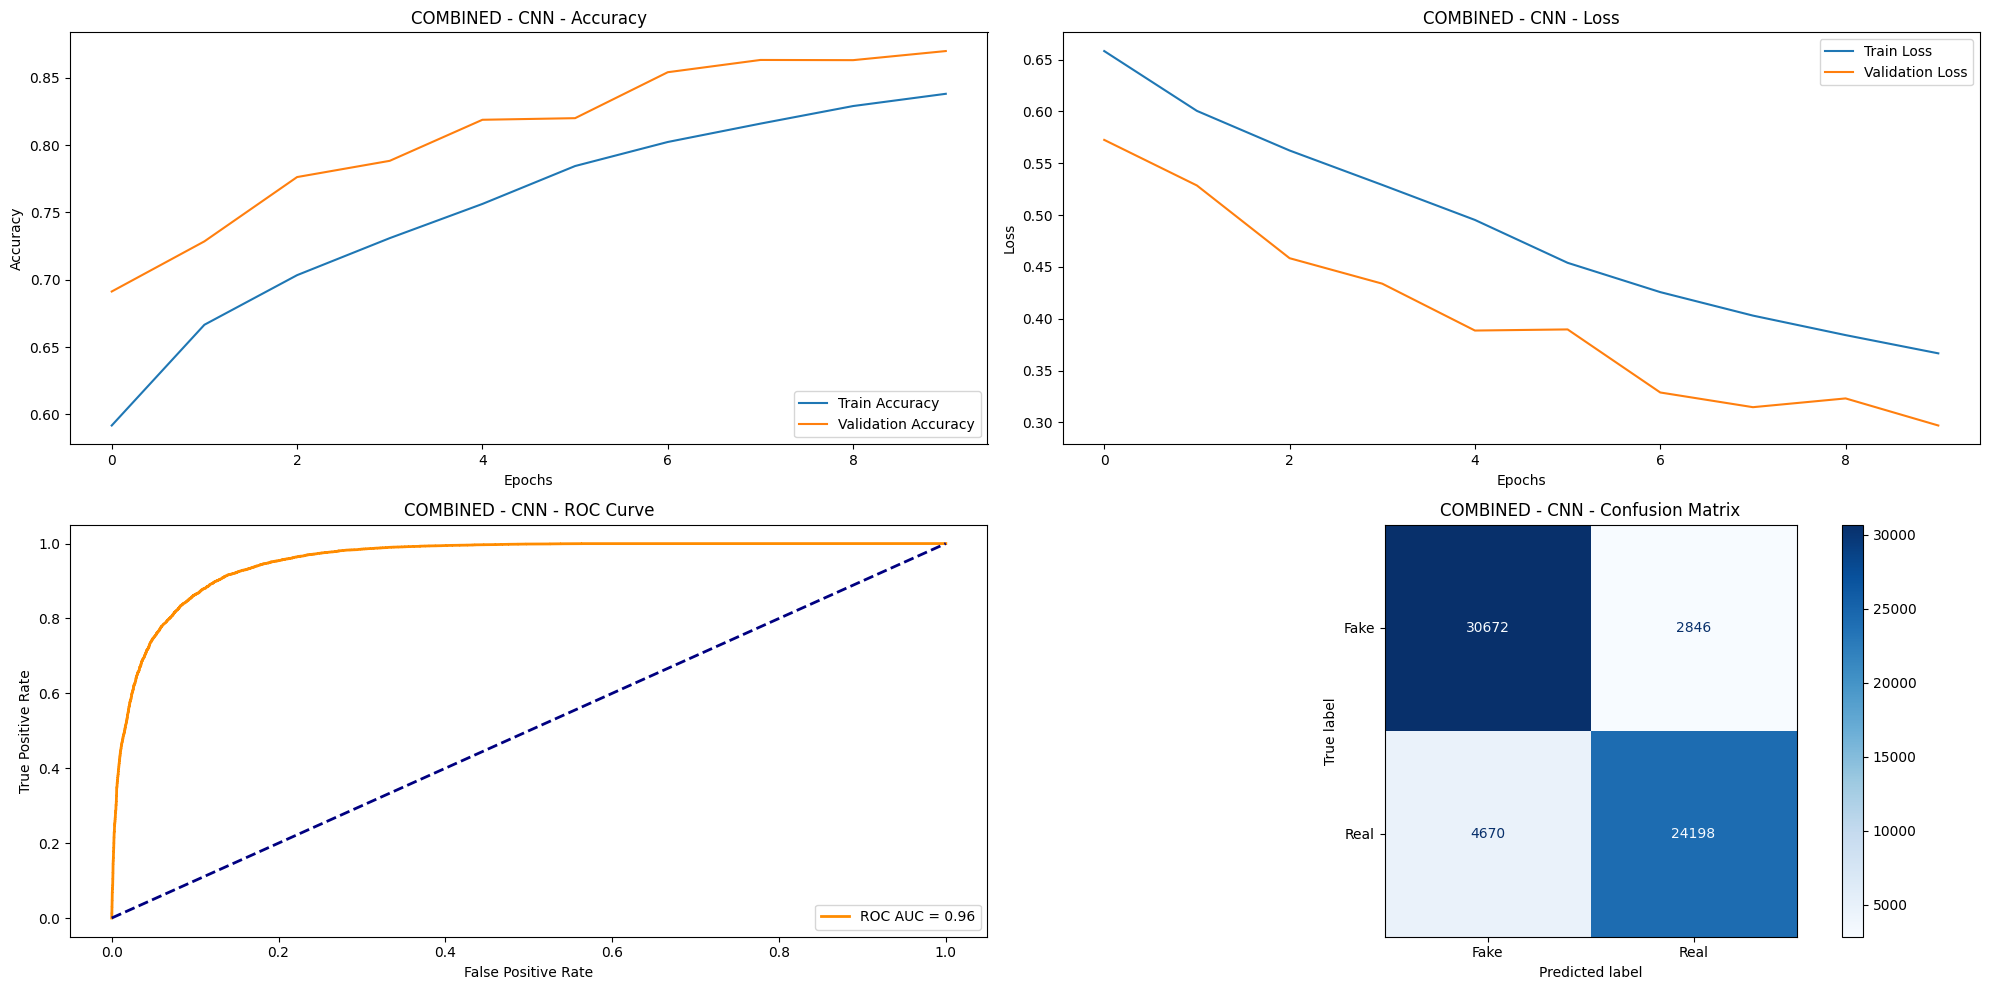

d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model 'CNN' for dataset 'COMBINED' saved at: cnn_combined.h5

--- Training RESNET model on COMBINED dataset ---
Epoch 1/10
7427/7427 [==============================] - 12660s 2s/step - loss: 0.6924 - accuracy: 0.5233 - auc: 0.4994 - val_loss: 0.6920 - val_accuracy: 0.5243 - val_auc: 0.5000
Epoch 2/10
7427/7427 [==============================] - 12568s 2s/step - loss: 0.6920 - accuracy: 0.5238 - auc: 0.4982 - val_loss: 0.6920 - val_accuracy: 0.5243 - val_auc: 0.5000
Epoch 3/10
7427/7427 [==============================] - 12412s 2s/step - loss: 0.6920 - accuracy: 0.5238 - auc: 0.4993 - val_loss: 0.6920 - val_accuracy: 0.5243 - val_auc: 0.5000
Epoch 4/10
7427/7427 [==============================] - 12564s 2s/step - loss: 0.6920 - accuracy: 0.5238 - auc: 0.4995 - val_loss: 0.6920 - val_accuracy: 0.5243 - val_auc: 0.5000
Epoch 5/10
7427/7427 [==============================] - 12646s 2s/step - loss: 0.6920 - accuracy: 0.5238 - auc: 0.5009 - val_loss: 0.6920 - val_accuracy: 0.5243 - val_auc: 

d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


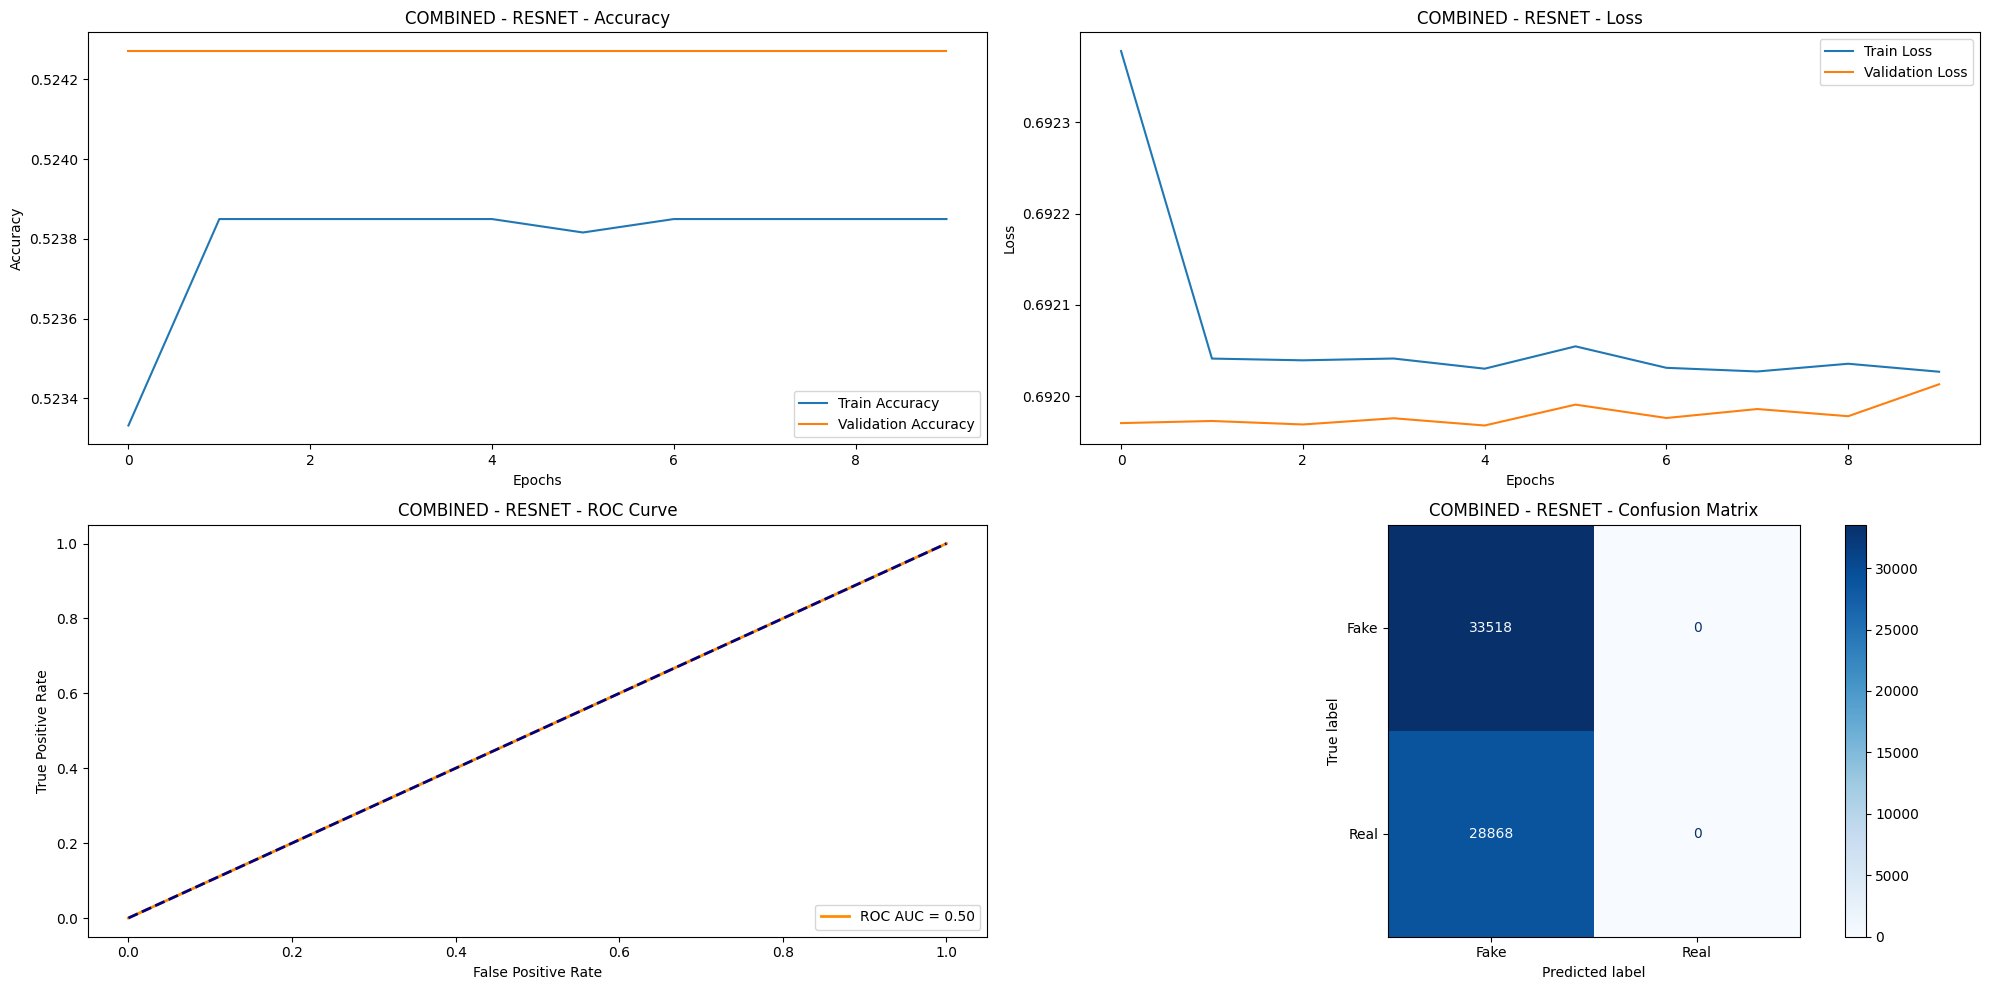

Model 'RESNET' for dataset 'COMBINED' saved at: resnet_combined.h5

--- Training MOBILENET model on COMBINED dataset ---


d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
7427/7427 [==============================] - 6159s 829ms/step - loss: 0.4491 - accuracy: 0.7835 - auc: 0.8688 - val_loss: 0.3216 - val_accuracy: 0.8554 - val_auc: 0.9393
Epoch 2/10
7427/7427 [==============================] - 5859s 789ms/step - loss: 0.4006 - accuracy: 0.8145 - auc: 0.8984 - val_loss: 0.2943 - val_accuracy: 0.8725 - val_auc: 0.9503
Epoch 3/10
7427/7427 [==============================] - 6004s 808ms/step - loss: 0.3871 - accuracy: 0.8217 - auc: 0.9061 - val_loss: 0.2922 - val_accuracy: 0.8772 - val_auc: 0.9531
Epoch 4/10
7427/7427 [==============================] - 5997s 807ms/step - loss: 0.3756 - accuracy: 0.8298 - auc: 0.9121 - val_loss: 0.2765 - val_accuracy: 0.8821 - val_auc: 0.9553
Epoch 5/10
7427/7427 [==============================] - 6185s 833ms/step - loss: 0.3707 - accuracy: 0.8314 - auc: 0.9145 - val_loss: 0.2828 - val_accuracy: 0.8775 - val_auc: 0.9559
Epoch 6/10
7427/7427 [==============================] - 6061s 816ms/step - loss: 0.3651 - accur

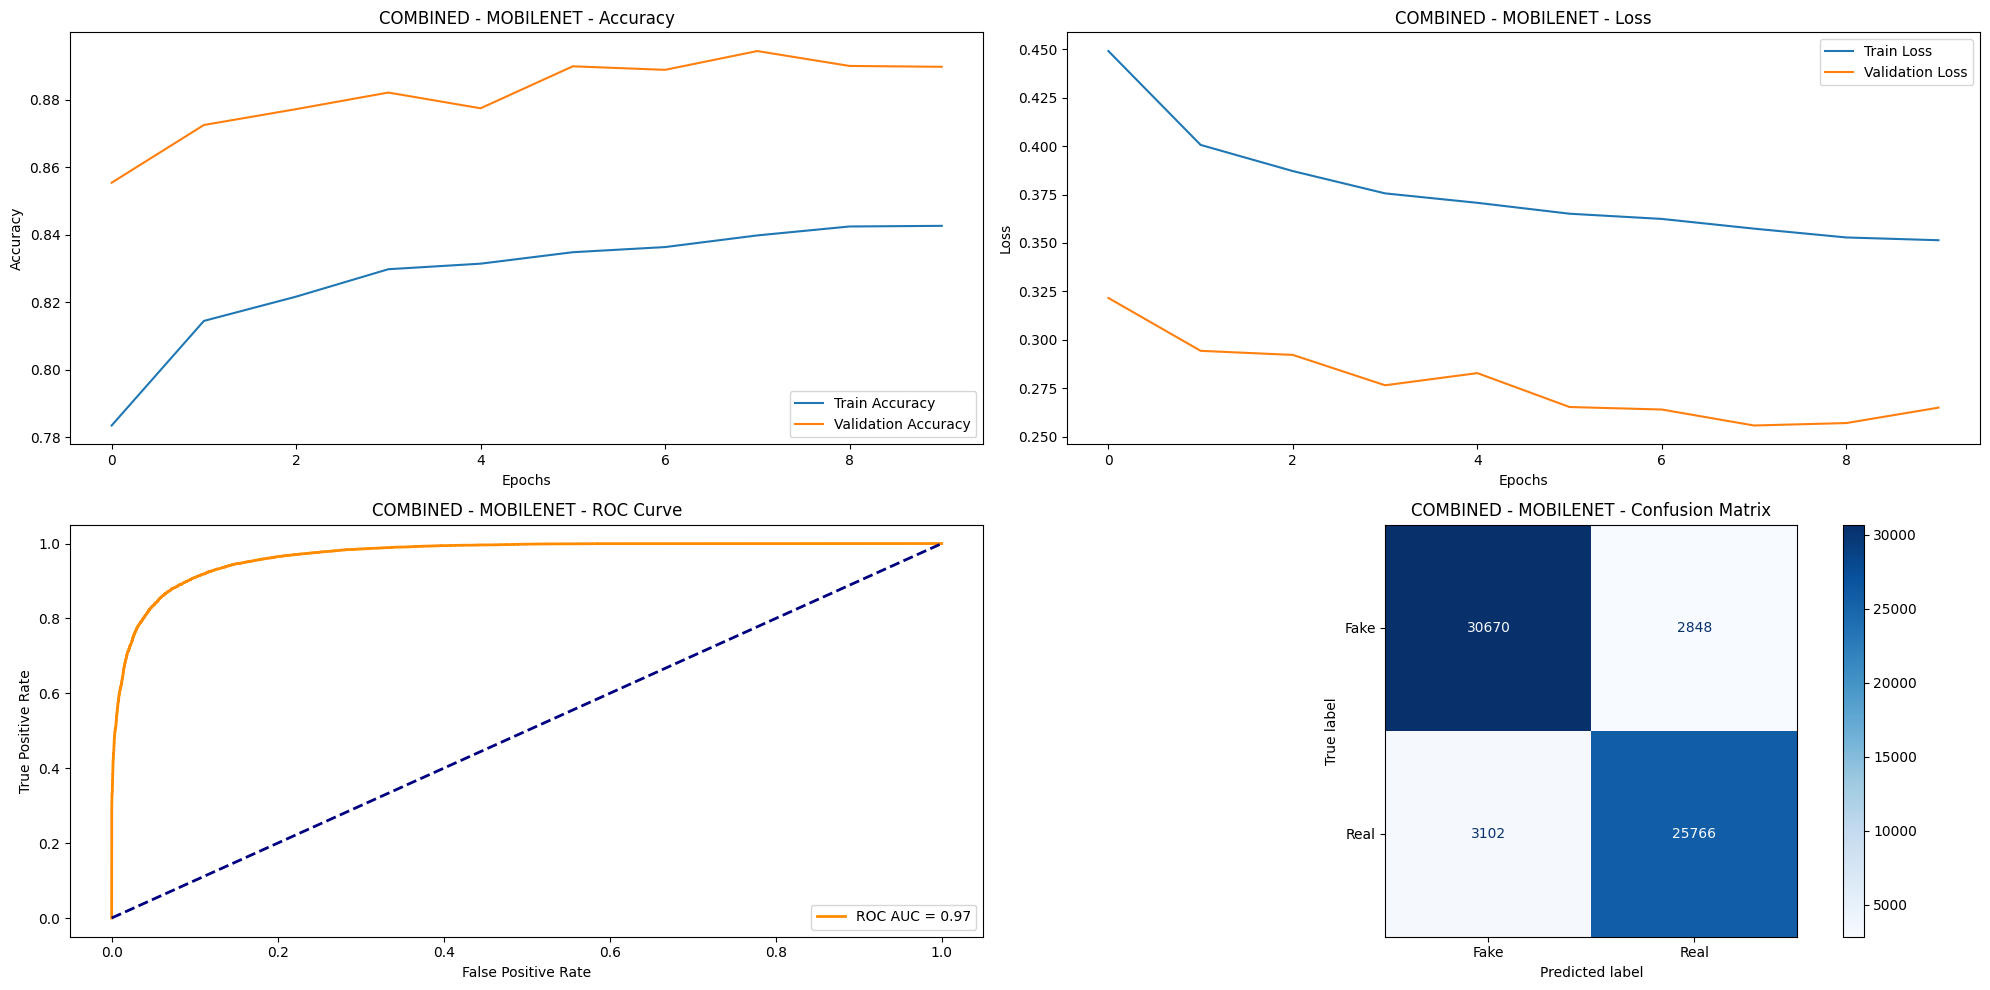

d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model 'MOBILENET' for dataset 'COMBINED' saved at: mobilenet_combined.h5

--- Training VGG16 model on COMBINED dataset ---
Epoch 1/10
7427/7427 [==============================] - 26020s 4s/step - loss: 0.6922 - accuracy: 0.5234 - auc: 0.5023 - val_loss: 0.6921 - val_accuracy: 0.5243 - val_auc: 0.5000
Epoch 2/10
7427/7427 [==============================] - 26033s 4s/step - loss: 0.6921 - accuracy: 0.5238 - auc: 0.4990 - val_loss: 0.6920 - val_accuracy: 0.5243 - val_auc: 0.5000
Epoch 3/10
7427/7427 [==============================] - 26841s 4s/step - loss: 0.6920 - accuracy: 0.5238 - auc: 0.4988 - val_loss: 0.6920 - val_accuracy: 0.5243 - val_auc: 0.5000
Epoch 4/10
7427/7427 [==============================] - 26295s 4s/step - loss: 0.6920 - accuracy: 0.5238 - auc: 0.4995 - val_loss: 0.6920 - val_accuracy: 0.5243 - val_auc: 0.5000
Epoch 5/10
7427/7427 [==============================] - 26916s 4s/step - loss: 0.6920 - accuracy: 0.5238 - auc: 0.4987 - val_loss: 0.6920 - val_accuracy: 0.5243 

d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


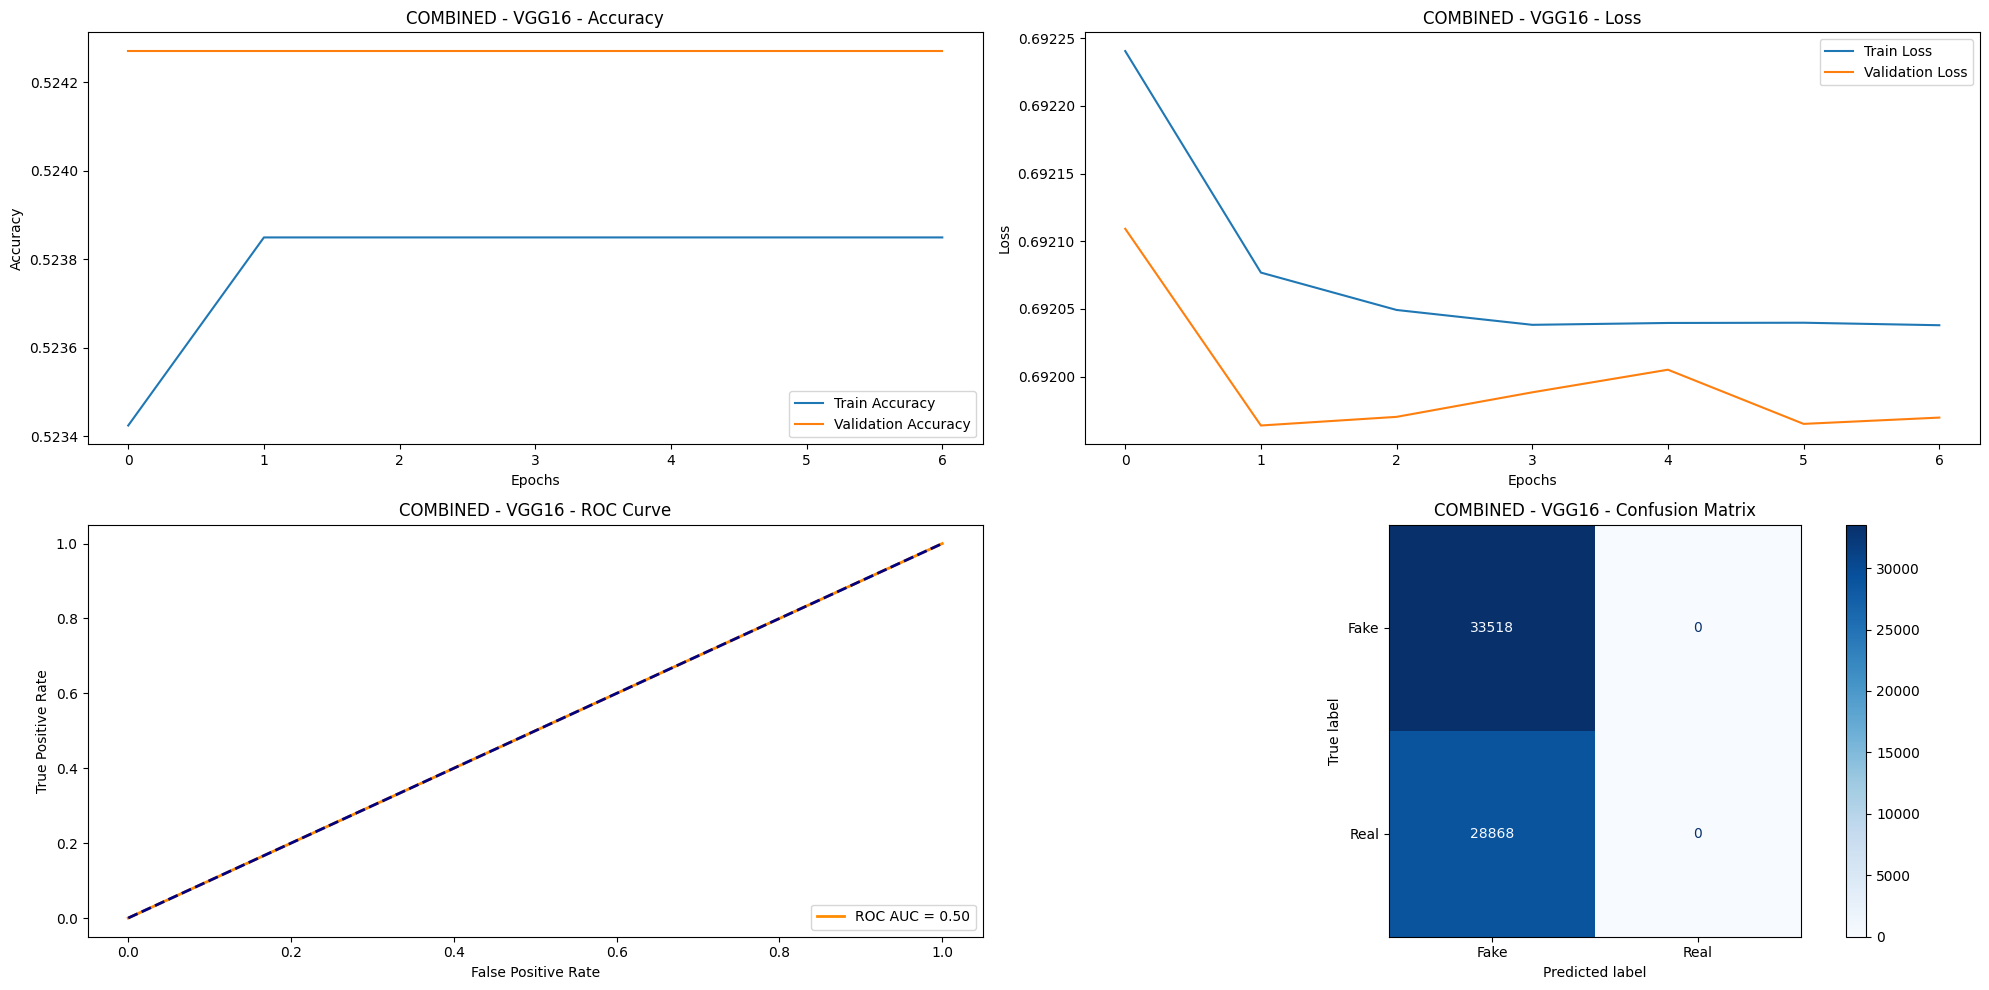

d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model 'VGG16' for dataset 'COMBINED' saved at: vgg16_combined.h5

Training and Evaluating on 140K Dataset
Found 200000 validated image filenames belonging to 2 classes.
Found 40000 validated image filenames belonging to 2 classes.
Found 40000 validated image filenames belonging to 2 classes.

--- Training CNN model on 140K dataset ---
Epoch 1/10
6250/6250 [==============================] - 7607s 1s/step - loss: 0.6912 - accuracy: 0.5228 - auc: 0.5372 - val_loss: 0.6725 - val_accuracy: 0.5880 - val_auc: 0.6334
Epoch 2/10


d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6250/6250 [==============================] - 7551s 1s/step - loss: 0.6635 - accuracy: 0.6029 - auc: 0.6406 - val_loss: 0.6602 - val_accuracy: 0.6007 - val_auc: 0.6970
Epoch 3/10
6250/6250 [==============================] - 7811s 1s/step - loss: 0.6377 - accuracy: 0.6424 - auc: 0.6916 - val_loss: 0.6025 - val_accuracy: 0.6864 - val_auc: 0.7640
Epoch 4/10
6250/6250 [==============================] - 7215s 1s/step - loss: 0.5777 - accuracy: 0.6985 - auc: 0.7683 - val_loss: 0.5210 - val_accuracy: 0.7494 - val_auc: 0.8272
Epoch 5/10
6250/6250 [==============================] - 7161s 1s/step - loss: 0.5129 - accuracy: 0.7497 - auc: 0.8269 - val_loss: 0.4688 - val_accuracy: 0.7836 - val_auc: 0.8629
Epoch 6/10
6250/6250 [==============================] - 6883s 1s/step - loss: 0.4750 - accuracy: 0.7761 - auc: 0.8553 - val_loss: 0.5251 - val_accuracy: 0.7650 - val_auc: 0.8917
Epoch 7/10
6250/6250 [==============================] - 7118s 1s/step - loss: 0.4443 - accuracy: 0.7960 - auc: 0.8749 - v

In [ ]:
# Dataset names and corresponding dataframes
dataset_configs = {
    "140k": dataframes,
    "deepfake": dataframes,
    "celebdf": dataframes,
    "combined": dataframes
}

dataset_order = ["combined", "140k", "celebdf"] # Define the desired dataset order
model_names = ['cnn', 'resnet', 'mobilenet', 'vgg16'] # Define the models to train

model_creation_functions = {
    'cnn': create_cnn_model,
    'resnet': create_resnet_model,
    'mobilenet': create_mobilenet_model,
    'vgg16': create_vgg16_model
}


for dataset_name in dataset_order:
    print(f"\n{'='*50}")
    print(f"Training and Evaluating on {dataset_name.upper()} Dataset")
    print(f"{'='*50}")

    train_df = dataframes[f'{dataset_name}_train']
    valid_df = dataframes[f'{dataset_name}_valid']
    test_df = dataframes[f'{dataset_name}_test']

    # --- Convert label column to string BEFORE creating generators ---
    train_df['label'] = train_df['label'].astype(str)
    valid_df['label'] = valid_df['label'].astype(str)
    test_df['label'] = test_df['label'].astype(str)

    if not train_df.empty and not valid_df.empty and not test_df.empty: # Check if dataframes are not empty
        train_generator, valid_generator, test_generator = create_generators(train_df, valid_df, test_df)

        for model_name in model_names:
            print(f"\n--- Training {model_name.upper()} model on {dataset_name.upper()} dataset ---")
            model_function = model_creation_functions[model_name]
            model = model_function() # Create the model
            train_and_evaluate(train_generator, valid_generator, test_generator, dataset_name, model, model_name)
    else:
        print(f"Warning: DataFrames for {dataset_name.upper()} dataset are empty. Skipping training and evaluation.")


print("\n--- Training and Evaluation Complete for All Datasets and Models ---")


Training and Evaluating on 140K Dataset
Found 200000 validated image filenames belonging to 2 classes.
Found 40000 validated image filenames belonging to 2 classes.
Found 40000 validated image filenames belonging to 2 classes.

--- Training CNN model on 140K dataset ---
Epoch 1/10
6250/6250 [==============================] - 7819s 1s/step - loss: 0.6671 - accuracy: 0.5909 - auc: 0.6316 - val_loss: 0.6102 - val_accuracy: 0.6681 - val_auc: 0.7320


d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
6250/6250 [==============================] - 6616s 1s/step - loss: 0.6146 - accuracy: 0.6647 - auc: 0.7248 - val_loss: 0.5709 - val_accuracy: 0.7020 - val_auc: 0.7858
Epoch 3/10
6250/6250 [==============================] - 6737s 1s/step - loss: 0.5665 - accuracy: 0.7095 - auc: 0.7801 - val_loss: 0.5141 - val_accuracy: 0.7508 - val_auc: 0.8379
Epoch 4/10
6250/6250 [==============================] - 6761s 1s/step - loss: 0.5065 - accuracy: 0.7556 - auc: 0.8326 - val_loss: 0.4498 - val_accuracy: 0.7881 - val_auc: 0.8704
Epoch 5/10
6250/6250 [==============================] - 6511s 1s/step - loss: 0.4627 - accuracy: 0.7841 - auc: 0.8635 - val_loss: 0.4204 - val_accuracy: 0.8085 - val_auc: 0.8926
Epoch 6/10
6250/6250 [==============================] - 7255s 1s/step - loss: 0.4321 - accuracy: 0.8031 - auc: 0.8826 - val_loss: 0.3820 - val_accuracy: 0.8305 - val_auc: 0.9098
Epoch 7/10
6250/6250 [==============================] - 7122s 1s/step - loss: 0.4080 - accuracy: 0.8164 - auc:

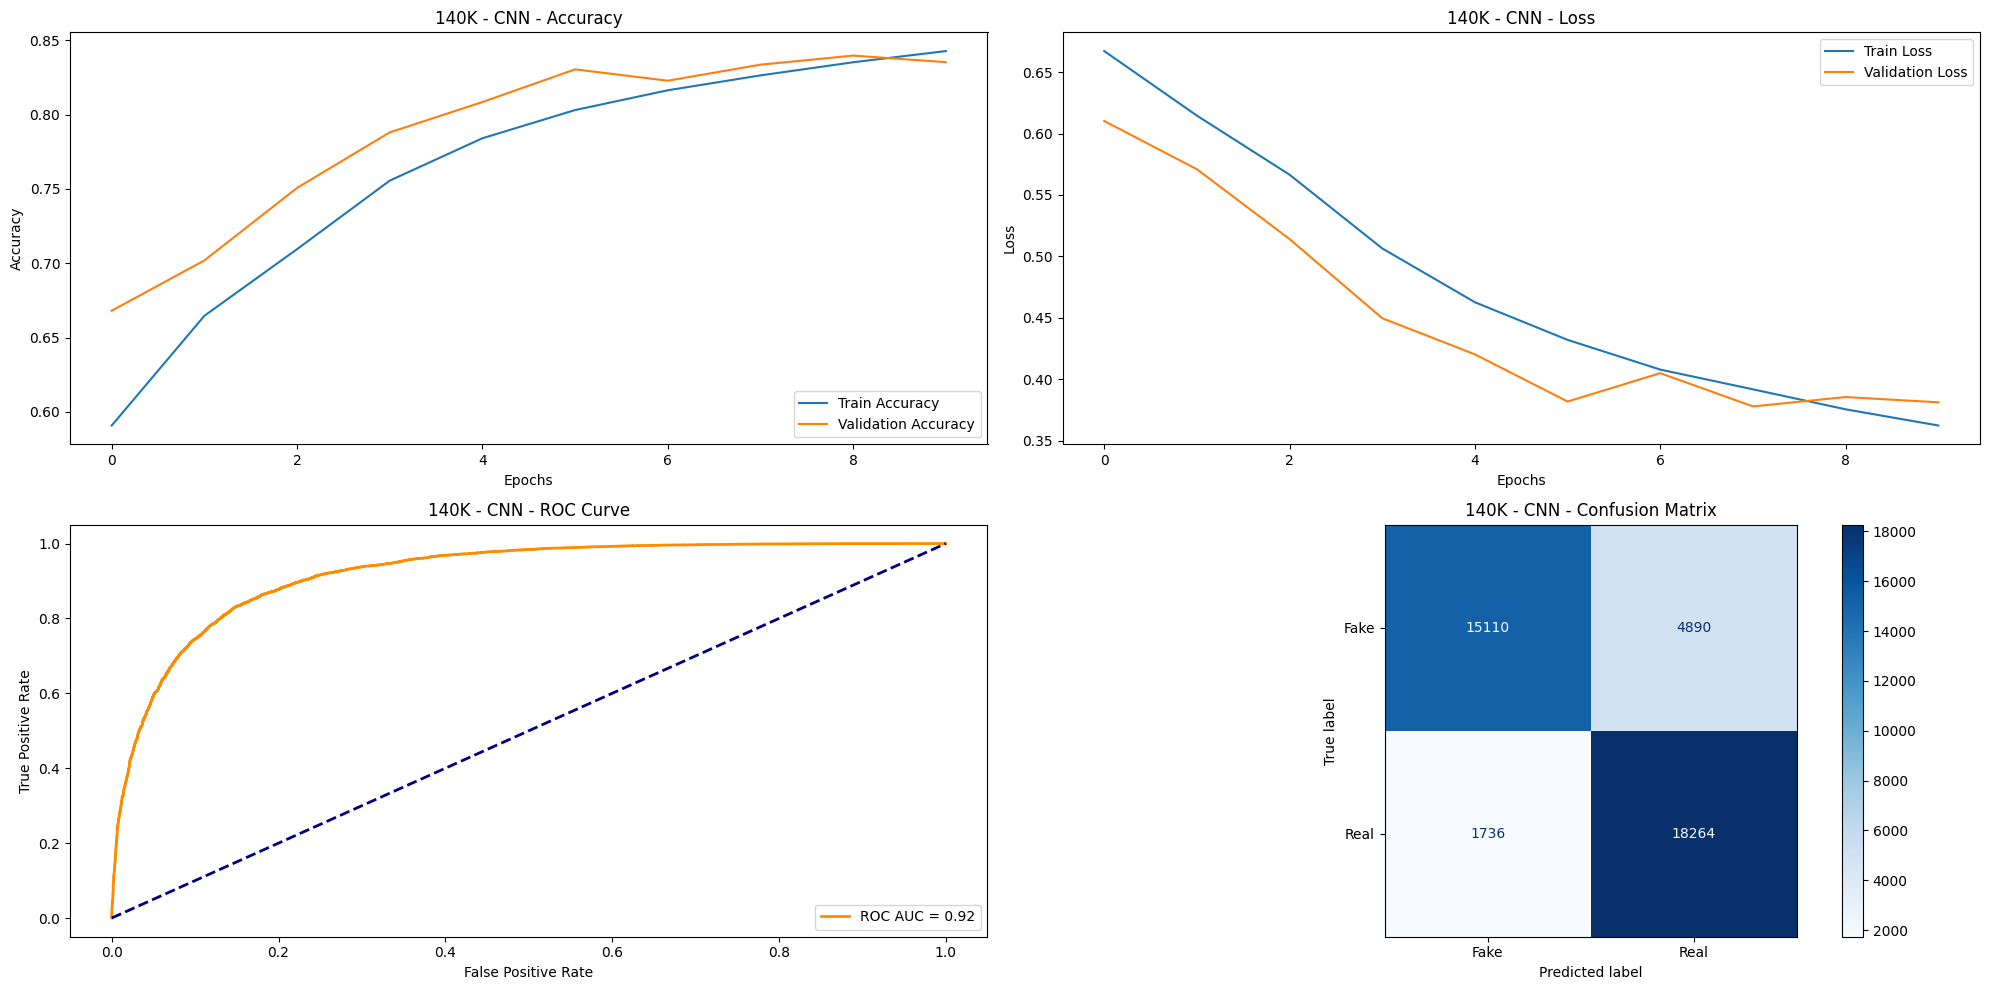

d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model 'CNN' for dataset '140K' saved at: cnn_140k.h5

--- Training RESNET model on 140K dataset ---
Epoch 1/10
6250/6250 [==============================] - 10679s 2s/step - loss: 0.6938 - accuracy: 0.5003 - auc: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/10
6250/6250 [==============================] - 10762s 2s/step - loss: 0.6932 - accuracy: 0.4982 - auc: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 3/10
6250/6250 [==============================] - 10821s 2s/step - loss: 0.6932 - accuracy: 0.4993 - auc: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 4/10
6250/6250 [==============================] - 10688s 2s/step - loss: 0.6932 - accuracy: 0.4982 - auc: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 5/10
6250/6250 [==============================] - 10762s 2s/step - loss: 0.6932 - accuracy: 0.4992 - auc: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch

d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


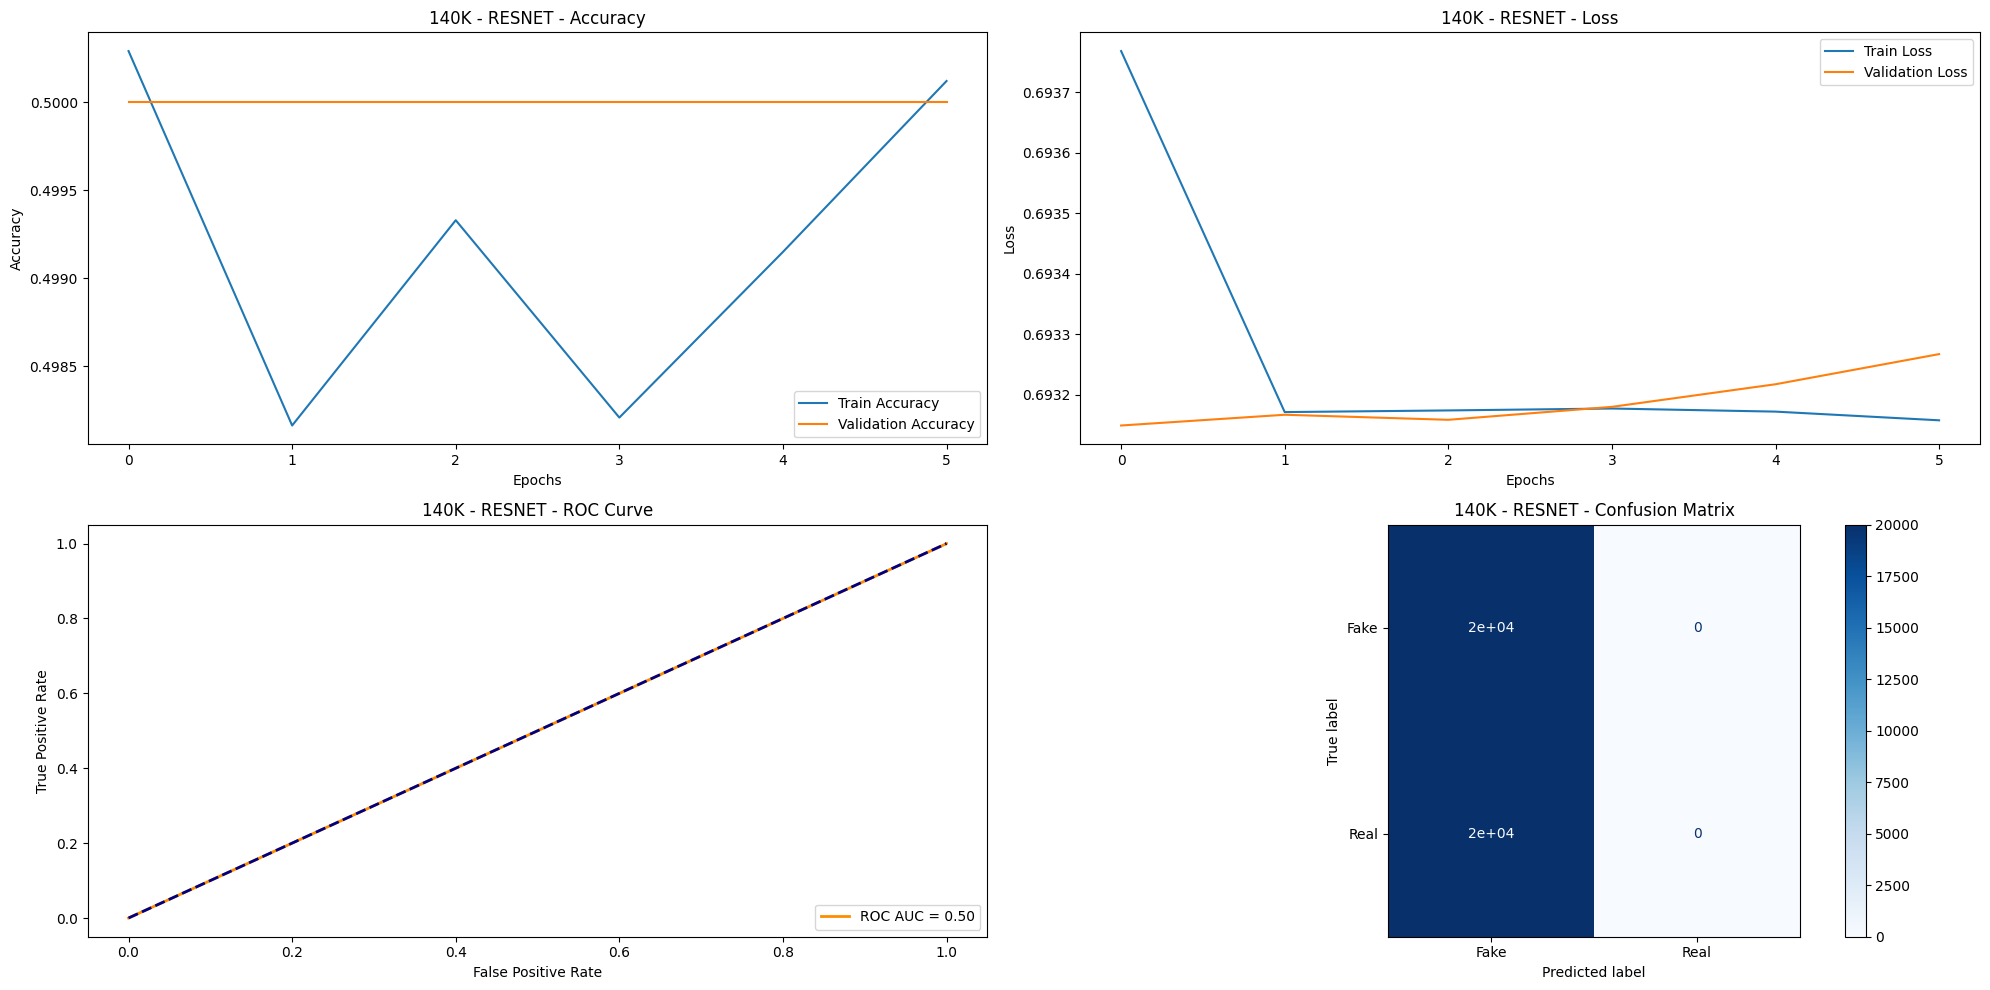

Model 'RESNET' for dataset '140K' saved at: resnet_140k.h5

--- Training MOBILENET model on 140K dataset ---


d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
6250/6250 [==============================] - 5000s 800ms/step - loss: 0.5012 - accuracy: 0.7555 - auc: 0.8352 - val_loss: 0.4171 - val_accuracy: 0.8130 - val_auc: 0.8950
Epoch 2/10
6250/6250 [==============================] - 4650s 744ms/step - loss: 0.4590 - accuracy: 0.7844 - auc: 0.8657 - val_loss: 0.4006 - val_accuracy: 0.8226 - val_auc: 0.9080
Epoch 3/10
6250/6250 [==============================] - 4501s 720ms/step - loss: 0.4440 - accuracy: 0.7950 - auc: 0.8756 - val_loss: 0.3756 - val_accuracy: 0.8350 - val_auc: 0.9136
Epoch 4/10
6250/6250 [==============================] - 4421s 707ms/step - loss: 0.4358 - accuracy: 0.7995 - auc: 0.8807 - val_loss: 0.3934 - val_accuracy: 0.8250 - val_auc: 0.9176
Epoch 5/10
6250/6250 [==============================] - 4246s 679ms/step - loss: 0.4305 - accuracy: 0.8023 - auc: 0.8840 - val_loss: 0.3615 - val_accuracy: 0.8414 - val_auc: 0.9204
Epoch 6/10
6250/6250 [==============================] - 4190s 670ms/step - loss: 0.4261 - accur

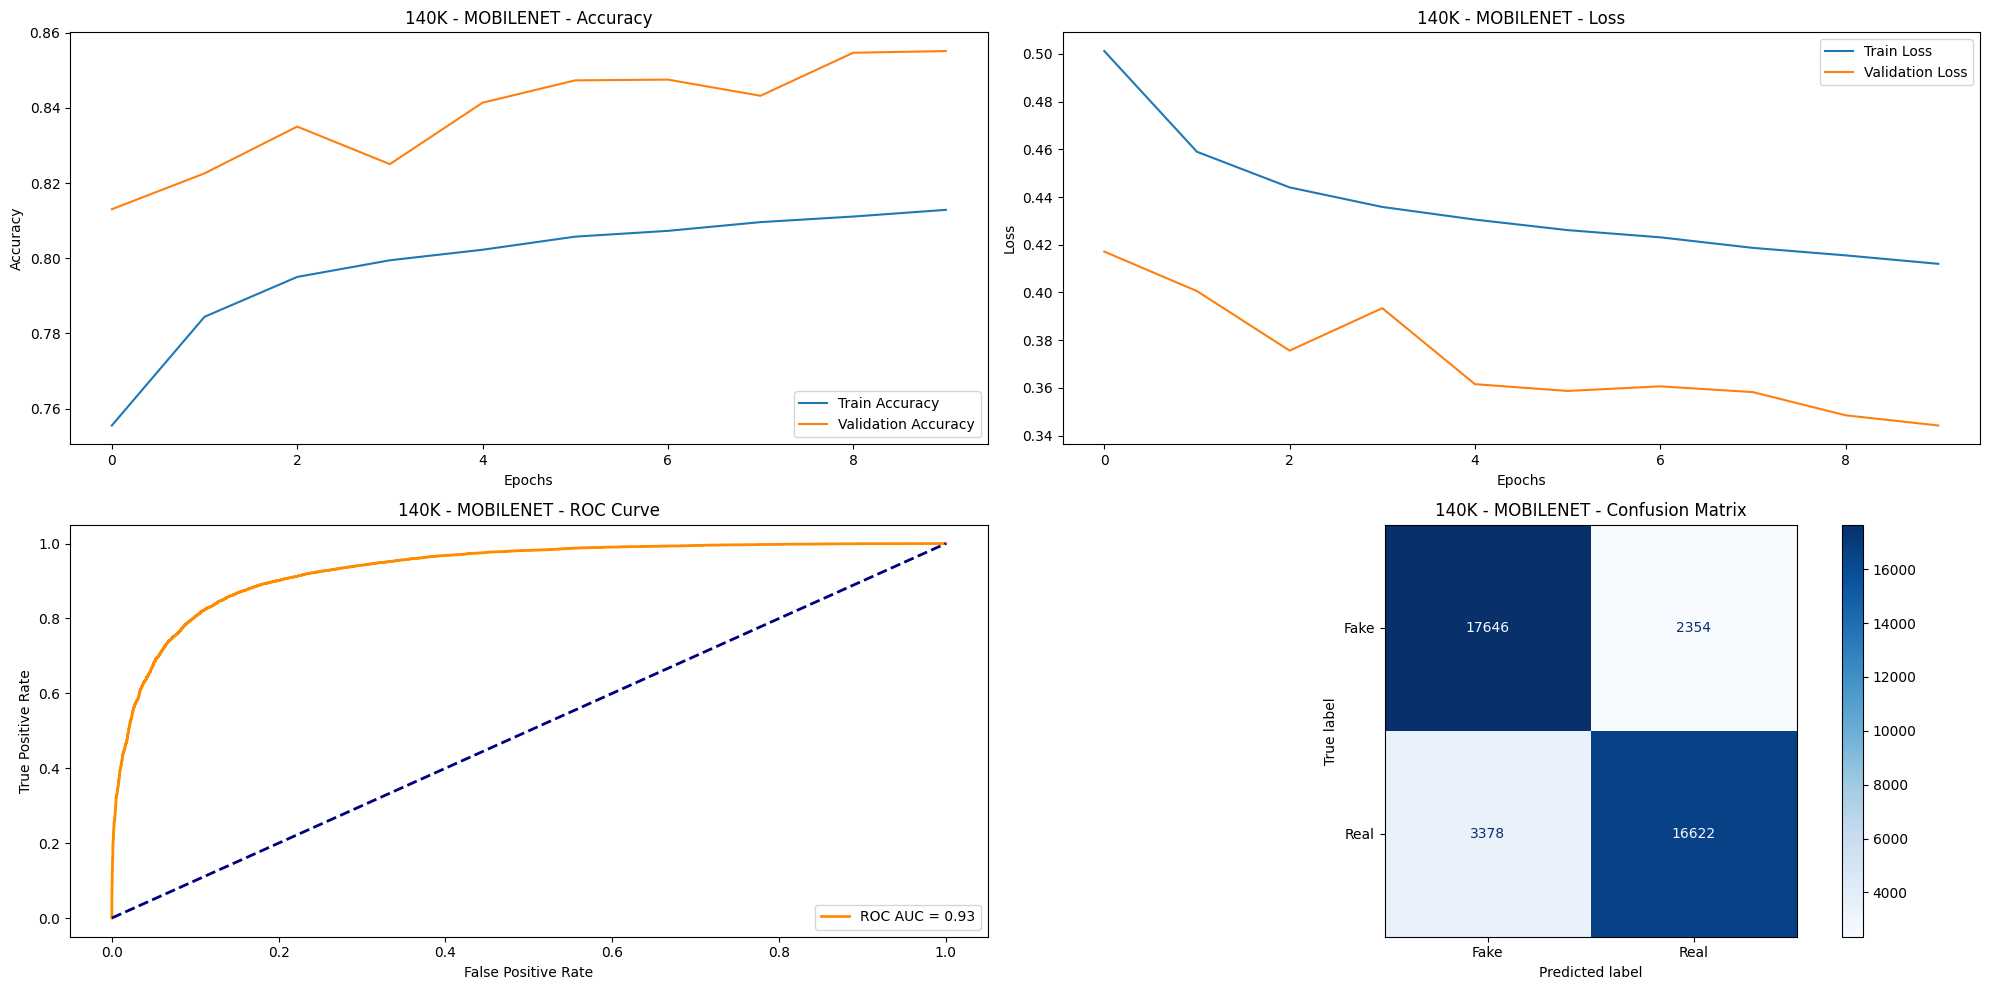

d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model 'MOBILENET' for dataset '140K' saved at: mobilenet_140k.h5

--- Training VGG16 model on 140K dataset ---
Epoch 1/10
6250/6250 [==============================] - 21381s 3s/step - loss: 0.6935 - accuracy: 0.5004 - auc: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/10
6250/6250 [==============================] - 21991s 4s/step - loss: 0.6932 - accuracy: 0.4987 - auc: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 3/10
6250/6250 [==============================] - 20603s 3s/step - loss: 0.6932 - accuracy: 0.5010 - auc: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 4/10
6250/6250 [==============================] - 20937s 3s/step - loss: 0.6932 - accuracy: 0.4987 - auc: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 5/10
6250/6250 [==============================] - 21612s 3s/step - loss: 0.6932 - accuracy: 0.4981 - auc: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_auc: 0

d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


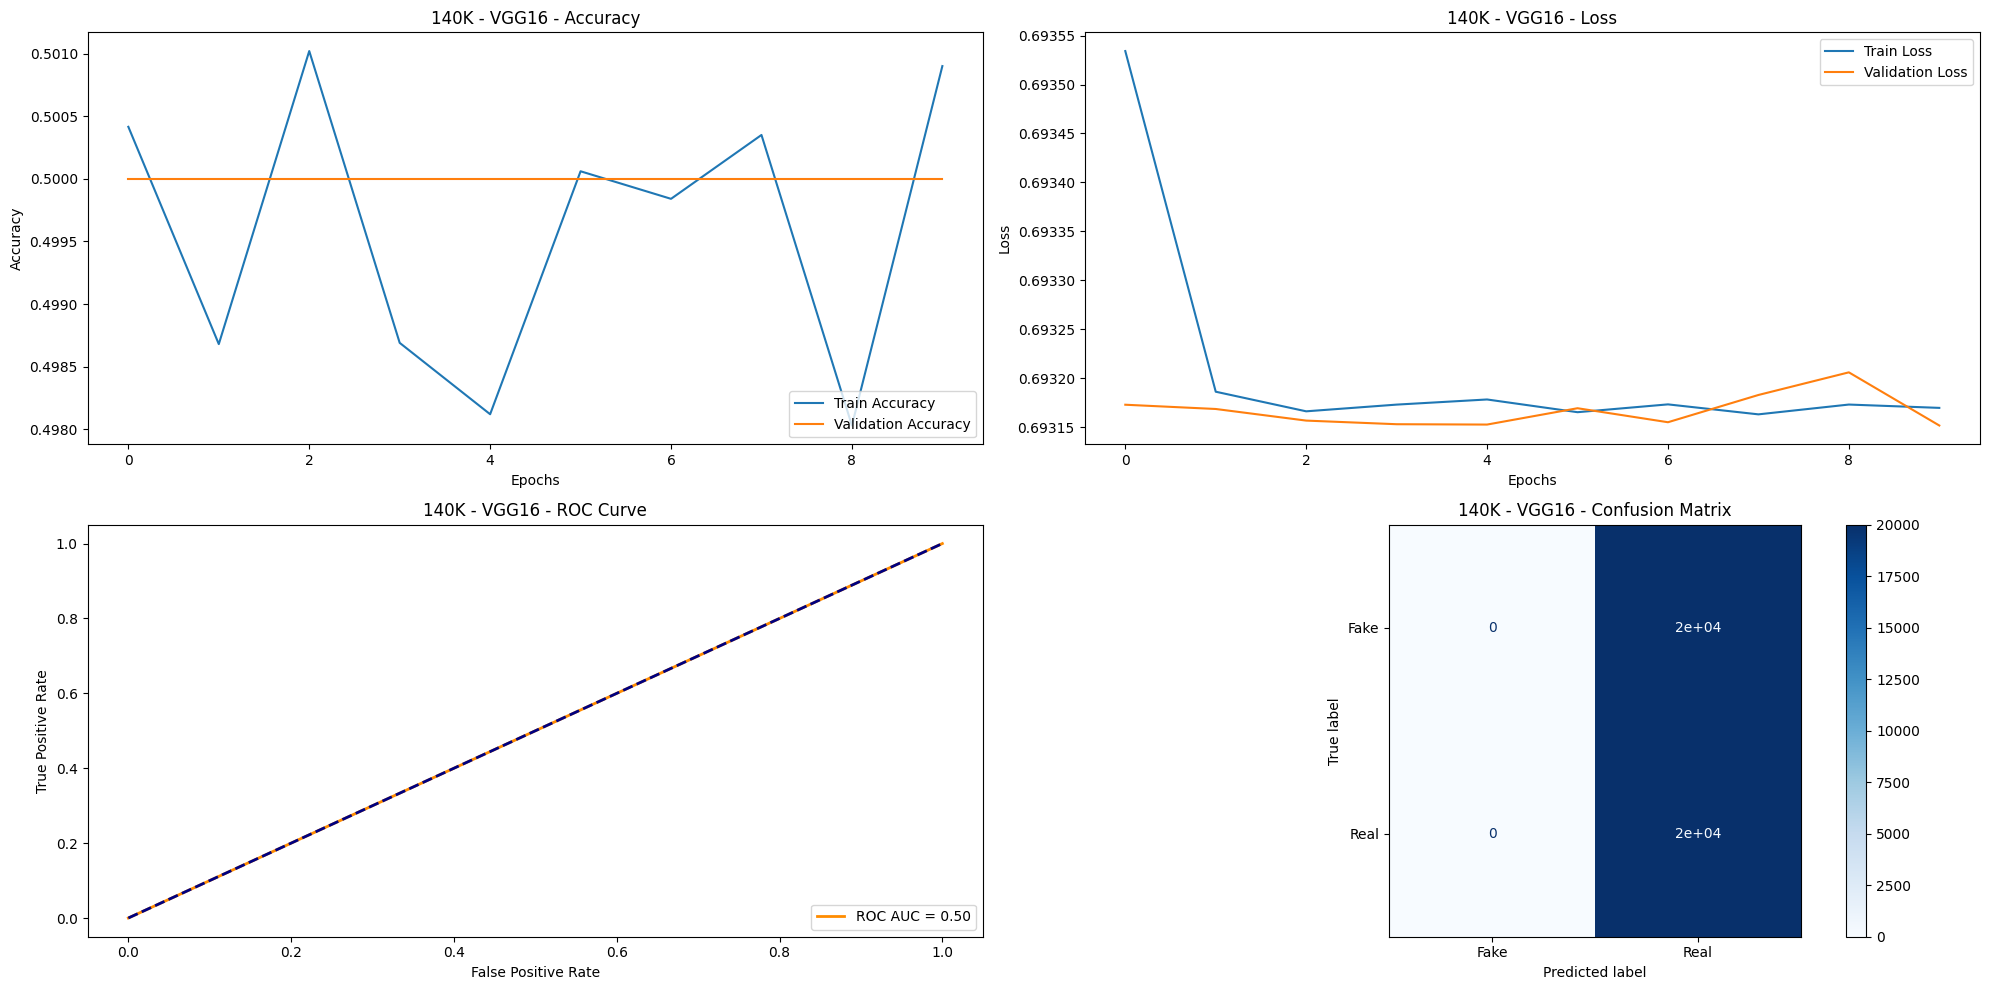

d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model 'VGG16' for dataset '140K' saved at: vgg16_140k.h5

Training and Evaluating on CELEBDF Dataset
Found 37854 validated image filenames belonging to 2 classes.
Found 15334 validated image filenames belonging to 2 classes.
Found 22386 validated image filenames belonging to 2 classes.

--- Training CNN model on CELEBDF dataset ---
Epoch 1/10
1183/1183 [==============================] - ETA: 0s - loss: 0.4789 - accuracy: 0.6670 - auc: 0.7533

d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1183/1183 [==============================] - 1448s 1s/step - loss: 0.4789 - accuracy: 0.6670 - auc: 0.7533 - val_loss: 0.4604 - val_accuracy: 0.7142 - val_auc: 0.8363
Epoch 2/10
1183/1183 [==============================] - 1409s 1s/step - loss: 0.4694 - accuracy: 0.6712 - auc: 0.7641 - val_loss: 0.4311 - val_accuracy: 0.7148 - val_auc: 0.9174
Epoch 3/10
1183/1183 [==============================] - 1275s 1s/step - loss: 0.4580 - accuracy: 0.7014 - auc: 0.7916 - val_loss: 0.4215 - val_accuracy: 0.8303 - val_auc: 0.9182
Epoch 4/10
1183/1183 [==============================] - 1266s 1s/step - loss: 0.4733 - accuracy: 0.7059 - auc: 0.7754 - val_loss: 0.6610 - val_accuracy: 0.6395 - val_auc: 0.6077
Epoch 5/10
1183/1183 [==============================] - 1369s 1s/step - loss: 0.4546 - accuracy: 0.7137 - auc: 0.7922 - val_loss: 0.4199 - val_accuracy: 0.8169 - val_auc: 0.9082
Epoch 6/10
1183/1183 [==============================] - 1432s 1s/step - loss: 0.4403 - accuracy: 0.7334 - auc: 0.8195 - v

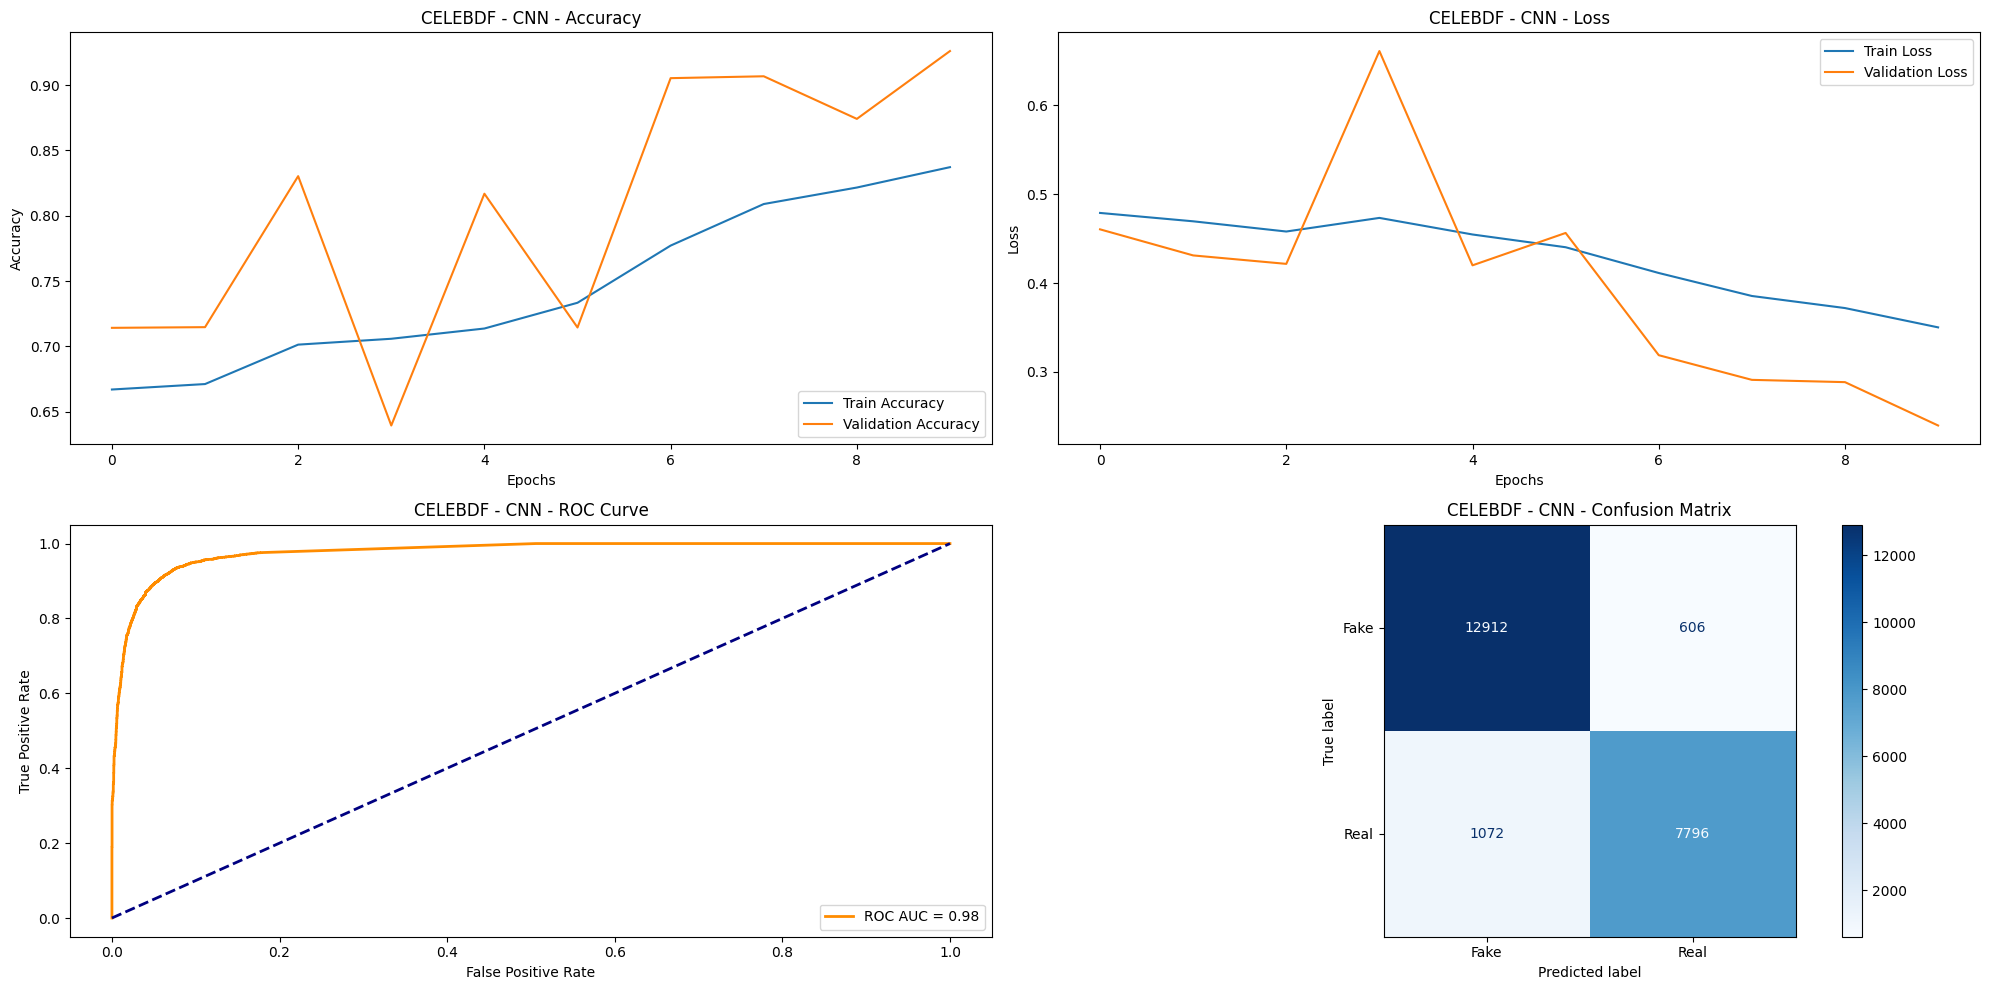

d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model 'CNN' for dataset 'CELEBDF' saved at: cnn_celebdf.h5

--- Training RESNET model on CELEBDF dataset ---
Epoch 1/10
1183/1183 [==============================] - 2395s 2s/step - loss: 0.6544 - accuracy: 0.6441 - auc: 0.5266 - val_loss: 0.6672 - val_accuracy: 0.5876 - val_auc: 0.8925
Epoch 2/10
1183/1183 [==============================] - 2321s 2s/step - loss: 0.6353 - accuracy: 0.6471 - auc: 0.5832 - val_loss: 0.6451 - val_accuracy: 0.5876 - val_auc: 0.9111
Epoch 3/10
1183/1183 [==============================] - 2318s 2s/step - loss: 0.6161 - accuracy: 0.6471 - auc: 0.6203 - val_loss: 0.6103 - val_accuracy: 0.5876 - val_auc: 0.9235
Epoch 4/10
1183/1183 [==============================] - 2305s 2s/step - loss: 0.5994 - accuracy: 0.6471 - auc: 0.6452 - val_loss: 0.5864 - val_accuracy: 0.5876 - val_auc: 0.9231
Epoch 5/10
1183/1183 [==============================] - 2295s 2s/step - loss: 0.6282 - accuracy: 0.6471 - auc: 0.5844 - val_loss: 0.6827 - val_accuracy: 0.5876 - val_auc: 0.5000
E

d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\tf213_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


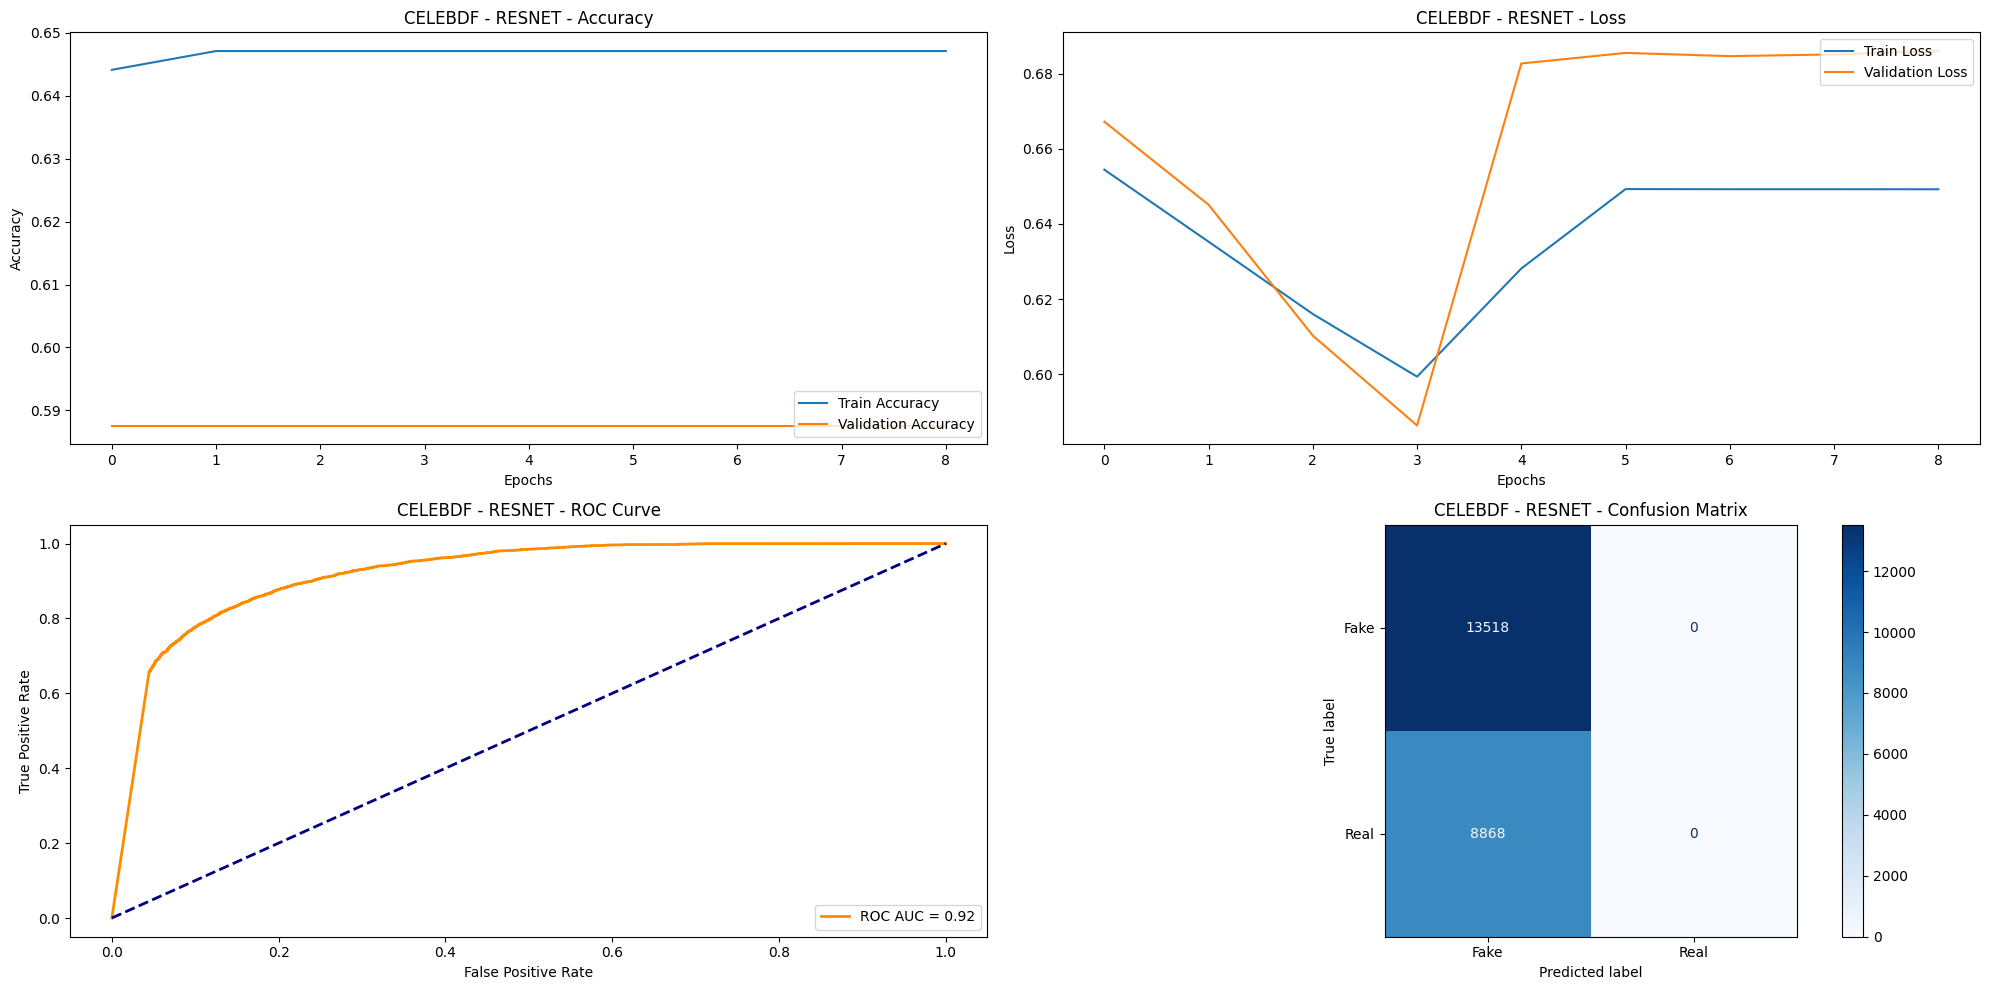

Model 'RESNET' for dataset 'CELEBDF' saved at: resnet_celebdf.h5

--- Training MOBILENET model on CELEBDF dataset ---


d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/10
1183/1183 [==============================] - 880s 742ms/step - loss: 0.1212 - accuracy: 0.9521 - auc: 0.9900 - val_loss: 0.0508 - val_accuracy: 0.9808 - val_auc: 0.9989
Epoch 2/10
1183/1183 [==============================] - 779s 658ms/step - loss: 0.0764 - accuracy: 0.9702 - auc: 0.9958 - val_loss: 0.0433 - val_accuracy: 0.9833 - val_auc: 0.9991
Epoch 3/10
1183/1183 [==============================] - 771s 652ms/step - loss: 0.0669 - accuracy: 0.9745 - auc: 0.9966 - val_loss: 0.0359 - val_accuracy: 0.9876 - val_auc: 0.9995
Epoch 4/10
1183/1183 [==============================] - 781s 660ms/step - loss: 0.0590 - accuracy: 0.9775 - auc: 0.9974 - val_loss: 0.0281 - val_accuracy: 0.9902 - val_auc: 0.9996
Epoch 5/10
1183/1183 [==============================] - 776s 656ms/step - loss: 0.0570 - accuracy: 0.9787 - auc: 0.9973 - val_loss: 0.0358 - val_accuracy: 0.9875 - val_auc: 0.9996
Epoch 6/10
1183/1183 [==============================] - 775s 655ms/step - loss: 0.0552 - accuracy: 0

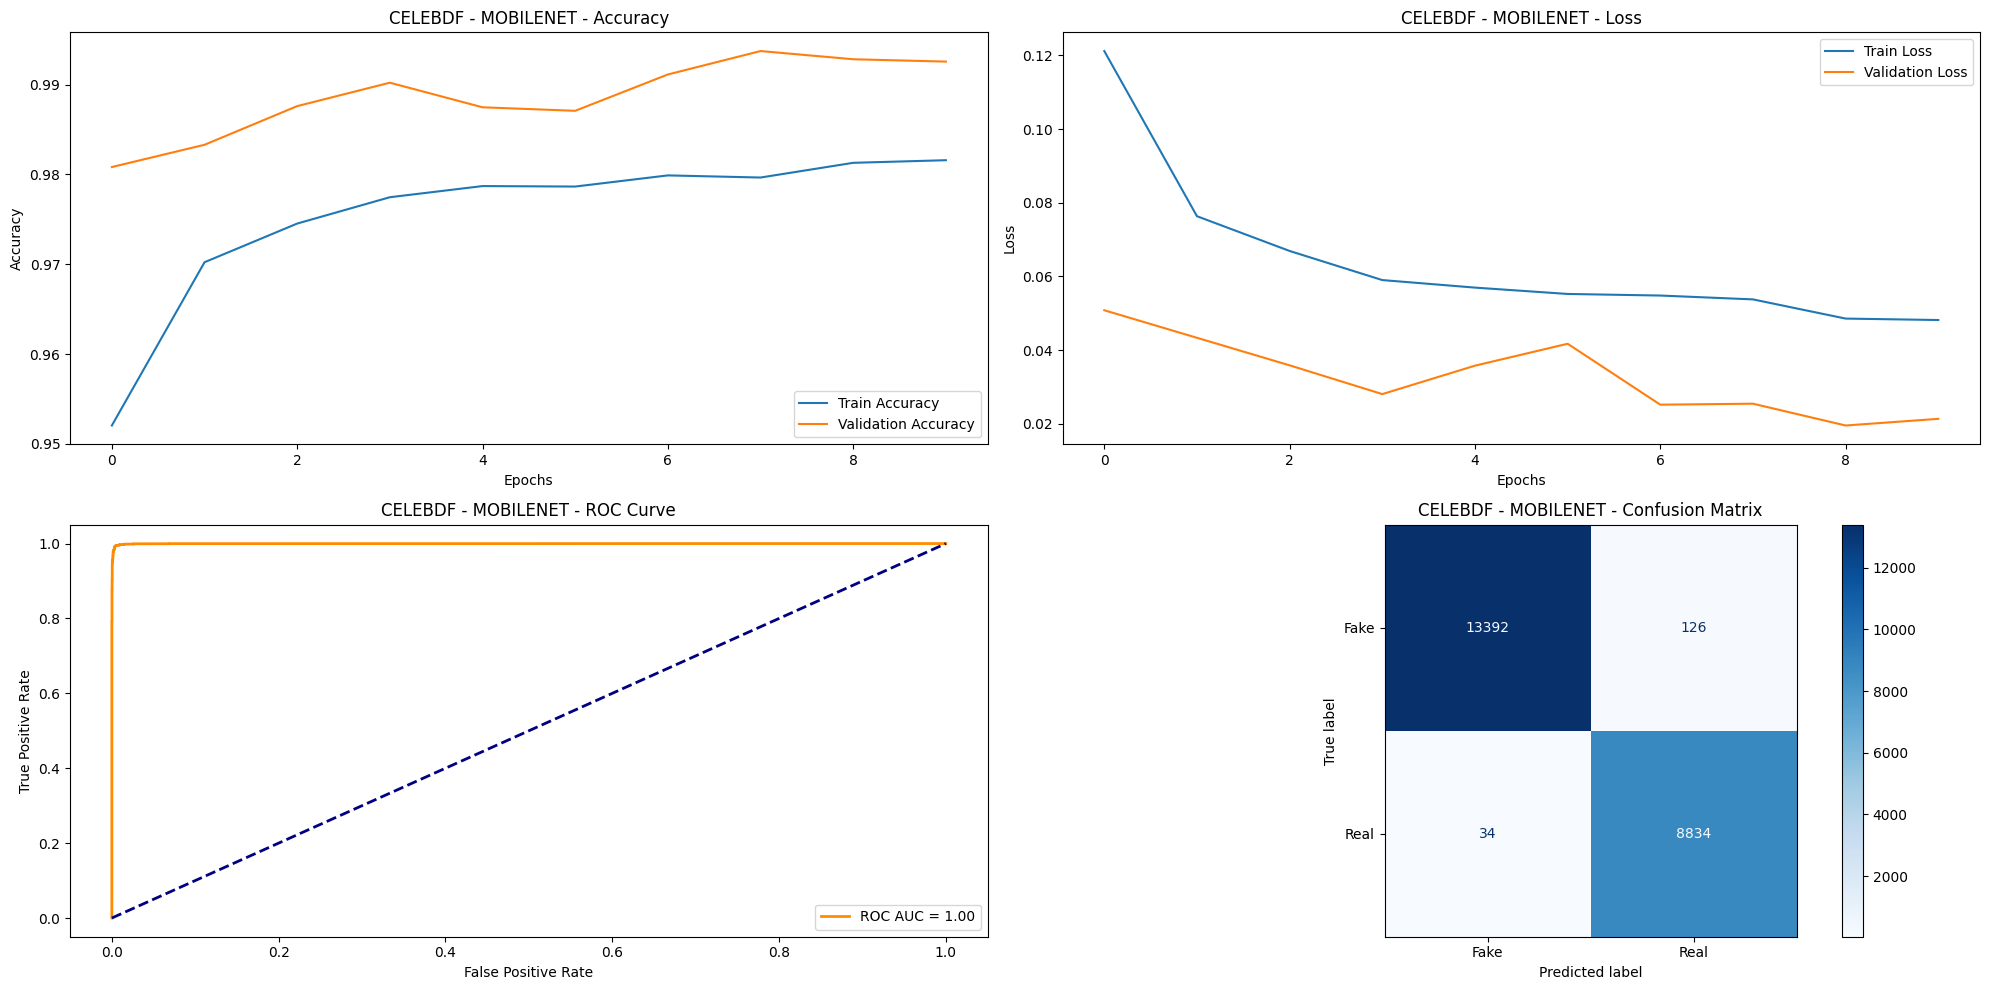

d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model 'MOBILENET' for dataset 'CELEBDF' saved at: mobilenet_celebdf.h5

--- Training VGG16 model on CELEBDF dataset ---
Epoch 1/10
1183/1183 [==============================] - 4862s 4s/step - loss: 0.1578 - accuracy: 0.9388 - auc: 0.9832 - val_loss: 0.0244 - val_accuracy: 0.9915 - val_auc: 0.9990
Epoch 2/10
1183/1183 [==============================] - 4864s 4s/step - loss: 0.0767 - accuracy: 0.9719 - auc: 0.9954 - val_loss: 0.0553 - val_accuracy: 0.9851 - val_auc: 0.9979
Epoch 3/10
1183/1183 [==============================] - 4850s 4s/step - loss: 0.0523 - accuracy: 0.9817 - auc: 0.9972 - val_loss: 0.0131 - val_accuracy: 0.9957 - val_auc: 0.9998
Epoch 4/10
1183/1183 [==============================] - 4884s 4s/step - loss: 0.0396 - accuracy: 0.9865 - auc: 0.9984 - val_loss: 0.0206 - val_accuracy: 0.9954 - val_auc: 0.9987
Epoch 5/10
1183/1183 [==============================] - 5106s 4s/step - loss: 0.0415 - accuracy: 0.9864 - auc: 0.9979 - val_loss: 0.0075 - val_accuracy: 0.9971 - val_au

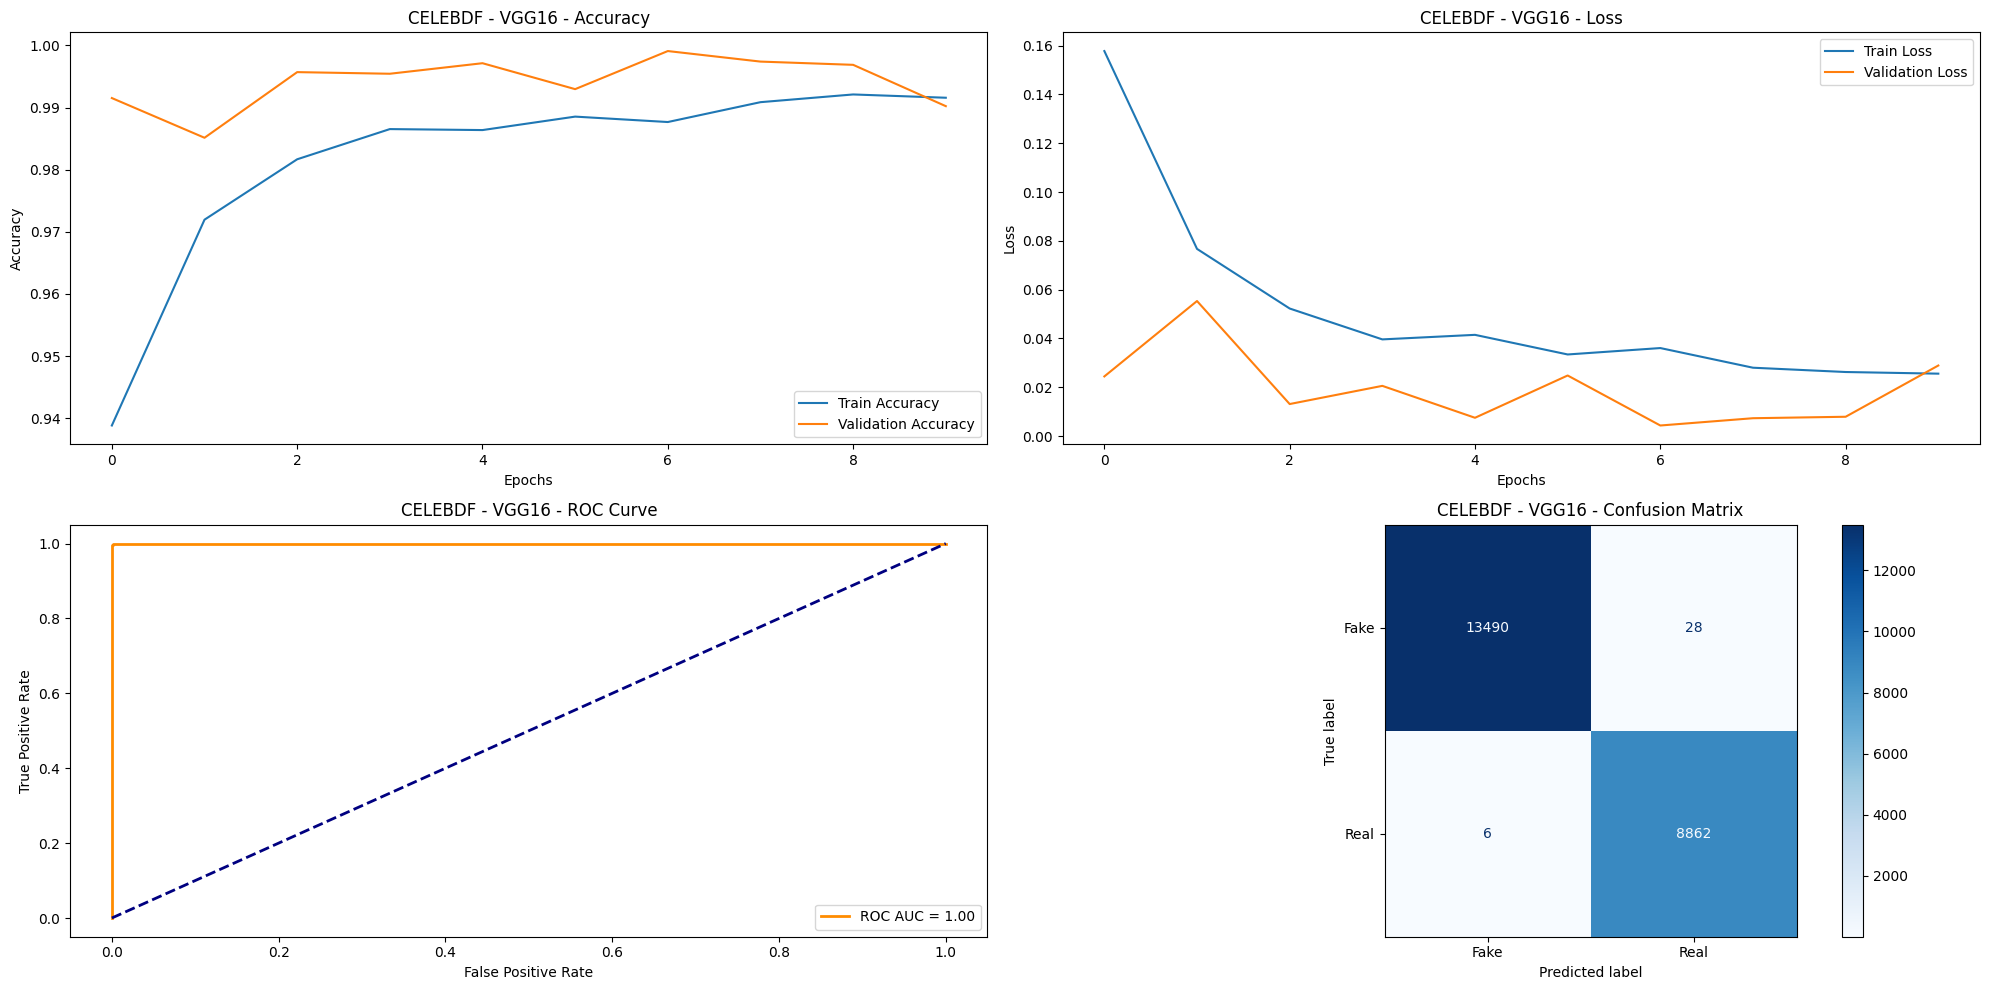

Model 'VGG16' for dataset 'CELEBDF' saved at: vgg16_celebdf.h5

--- Training and Evaluation Complete for All Datasets and Models ---


d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Dataset names and corresponding dataframes
dataset_configs = {
    "140k": dataframes,
    "deepfake": dataframes,
    "celebdf": dataframes,
    "combined": dataframes
}

dataset_order = ["140k", "celebdf"] # Define the desired dataset order
model_names = ['cnn', 'resnet', 'mobilenet', 'vgg16'] # Define the models to train

model_creation_functions = {
    'cnn': create_cnn_model,
    'resnet': create_resnet_model,
    'mobilenet': create_mobilenet_model,
    'vgg16': create_vgg16_model
}


for dataset_name in dataset_order:
    print(f"\n{'='*50}")
    print(f"Training and Evaluating on {dataset_name.upper()} Dataset")
    print(f"{'='*50}")

    train_df = dataframes[f'{dataset_name}_train']
    valid_df = dataframes[f'{dataset_name}_valid']
    test_df = dataframes[f'{dataset_name}_test']

    # --- Convert label column to string BEFORE creating generators ---
    train_df['label'] = train_df['label'].astype(str)
    valid_df['label'] = valid_df['label'].astype(str)
    test_df['label'] = test_df['label'].astype(str)

    if not train_df.empty and not valid_df.empty and not test_df.empty: # Check if dataframes are not empty
        train_generator, valid_generator, test_generator = create_generators(train_df, valid_df, test_df)

        for model_name in model_names:
            print(f"\n--- Training {model_name.upper()} model on {dataset_name.upper()} dataset ---")
            model_function = model_creation_functions[model_name]
            model = model_function() # Create the model
            train_and_evaluate(train_generator, valid_generator, test_generator, dataset_name, model, model_name)
    else:
        print(f"Warning: DataFrames for {dataset_name.upper()} dataset are empty. Skipping training and evaluation.")


print("\n--- Training and Evaluation Complete for All Datasets and Models ---")

In [28]:
# Dataset names and corresponding dataframes
dataset_configs = {
    "140k": dataframes,
    "deepfake": dataframes,
    "celebdf": dataframes,
    "combined": dataframes
}

dataset_order = ["deepfake"] # Define the desired dataset order
model_names = ['cnn', 'resnet', 'mobilenet', 'vgg16'] # Define the models to train

model_creation_functions = {
    'cnn': create_cnn_model,
    'resnet': create_resnet_model,
    'mobilenet': create_mobilenet_model,
    'vgg16': create_vgg16_model
}


for dataset_name in dataset_order:
    print(f"\n{'='*50}")
    print(f"Training and Evaluating on {dataset_name.upper()} Dataset")
    print(f"{'='*50}")

    train_df = dataframes[f'{dataset_name}_train']
    valid_df = dataframes[f'{dataset_name}_valid']
    test_df = dataframes[f'{dataset_name}_test']

    # --- Convert label column to string BEFORE creating generators ---
    train_df['label'] = train_df['label'].astype(str)
    valid_df['label'] = valid_df['label'].astype(str)
    test_df['label'] = test_df['label'].astype(str)

    if not train_df.empty and not valid_df.empty and not test_df.empty: # Check if dataframes are not empty
        train_generator, valid_generator, test_generator = create_generators(train_df, valid_df, test_df)

        for model_name in model_names:
            print(f"\n--- Training {model_name.upper()} model on {dataset_name.upper()} dataset ---")
            model_function = model_creation_functions[model_name]
            model = model_function() # Create the model
            train_and_evaluate(train_generator, valid_generator, test_generator, dataset_name, model, model_name)
    else:
        print(f"Warning: DataFrames for {dataset_name.upper()} dataset are empty. Skipping training and evaluation.")


print("\n--- Training and Evaluation Complete for All Datasets and Models ---")


Training and Evaluating on DEEPFAKE Dataset
Found 280004 validated image filenames belonging to 2 classes.
Found 78856 validated image filenames belonging to 2 classes.
Found 21810 validated image filenames belonging to 2 classes.

--- Training CNN model on DEEPFAKE dataset ---
Epoch 1/10
  71/8751 [..............................] - ETA: 4:50:54 - loss: 0.7713 - accuracy: 0.4872 - auc: 0.4896

KeyboardInterrupt: 


--- Predicting with CNN Model ---
Model loading time: 0.3673 seconds
Prediction time: 0.1036 seconds
Total latency: 0.4709 seconds


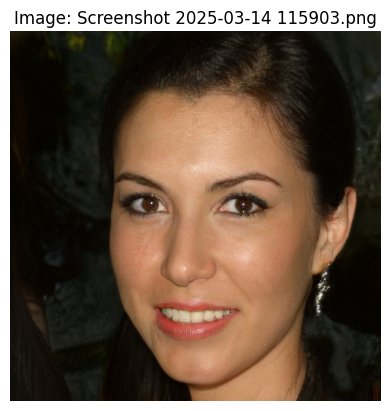

Prediction Score: 0.79812825
Prediction: REAL

--- Predicting with RESNET Model ---
Model loading time: 1.5590 seconds
Prediction time: 1.2582 seconds
Total latency: 2.8172 seconds


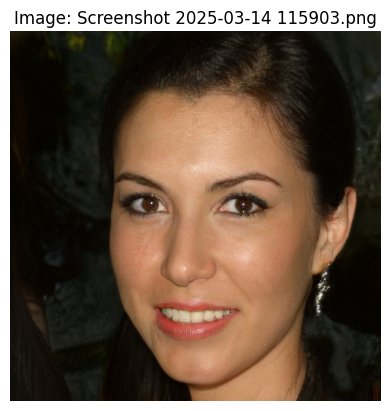

Prediction Score: 0.4766382
Prediction: FAKE

--- Predicting with MOBILENET Model ---
Model loading time: 0.6003 seconds
Prediction time: 0.3375 seconds
Total latency: 0.9378 seconds


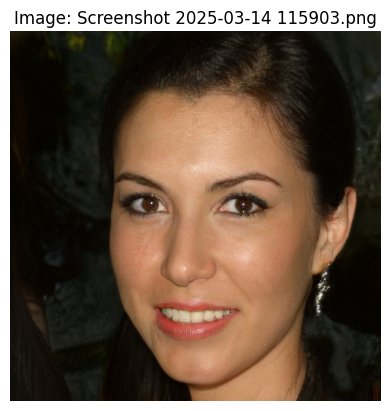

Prediction Score: 0.07238921
Prediction: FAKE

--- Predicting with VGG16 Model ---
Model loading time: 0.4124 seconds
Prediction time: 0.2489 seconds
Total latency: 0.6613 seconds


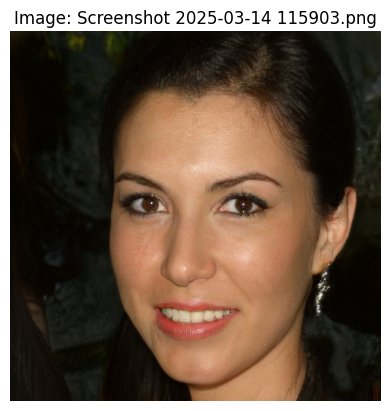

Prediction Score: 0.47420266
Prediction: FAKE

--- Predicting with LFAT Model ---
Model loading time: 1.5551 seconds
Prediction time: 0.8948 seconds
Total latency: 2.4499 seconds


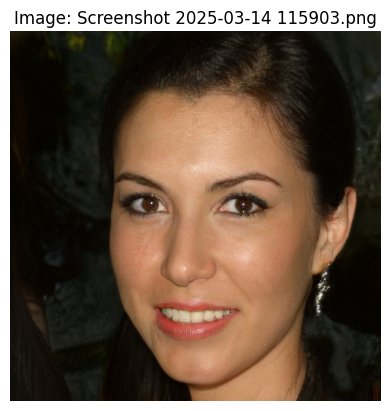

Prediction Score: 0.02243881
Prediction: FAKE

--- Model Latency Comparison ---
Model      Load (s)   Predict (s)  Total (s)  Prediction   Confidence
----------------------------------------------------------------------
cnn        0.3673     0.1036       0.4709     REAL         0.7981    
resnet     1.5590     1.2582       2.8172     FAKE         0.4766    
mobilenet  0.6003     0.3375       0.9378     FAKE         0.0724    
vgg16      0.4124     0.2489       0.6613     FAKE         0.4742    
lfat       1.5551     0.8948       2.4499     FAKE         0.0224    


In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import time  # Import time module for latency measurement
from tensorflow.keras import layers, models, optimizers # Import layers and models for custom layers
from tensorflow.keras.applications import MobileNetV2 # Import MobileNetV2 for the base model
from tensorflow.keras.utils import CustomObjectScope # Import CustomObjectScope

# --- USER-ADJUSTABLE PARAMETERS (Ensure these match your training setup) ---
# Default IMAGE_SIZE, can be overridden per model
DEFAULT_IMAGE_SIZE = (256, 256)

# Model-specific IMAGE_SIZE overrides
MODEL_IMAGE_SIZES = {
    'lfat': (224, 224),
    # Add other model-specific sizes here if needed
}

# --- MODEL NAMES - Should match the names you used during training and saving ---
model_names = ['cnn', 'resnet', 'mobilenet', 'vgg16', 'lfat'] # Added 'lfat' to the list
dataset_name = 'combined'  # Or whichever dataset you trained on and want to test with

# --- Base directory where your models are saved ---
BASE_MODEL_DIR = 'd:/deepfake'  # <---  Set your base model directory here


# --- CUSTOM LAYERS DEFINITIONS (Copy from your training script) ---
def transformer_encoder(inputs, num_heads, key_dim, ffn_dim, num_layers):
    x = inputs
    for _ in range(num_layers):
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization()(x)
        ffn_output = layers.Dense(ffn_dim, activation='relu')(x)
        ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization()(x)
    return x


class FrequencyAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FrequencyAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        cnn_feature_shape, freq_map_shape = input_shape
        self.channel_attention = layers.Dense(cnn_feature_shape[-1], activation='sigmoid') # Learn channel weights

    def call(self, inputs):
        cnn_features, freq_map = inputs

        # Global Average Pooling on Frequency Map
        frequency_attention_vector = tf.keras.layers.GlobalAveragePooling2D()(freq_map) # Shape (B, 1, 1) or (B, 1)

        # Learnable Transformation (FC layer to get channel weights)
        attention_weights = self.channel_attention(frequency_attention_vector) # Output shape (B, C), C = num_channels of cnn_features

        # Channel-wise Multiplication - Reshape weights to be broadcastable
        attention_weights = tf.reshape(attention_weights, (-1, 1, 1, cnn_features.shape[-1])) # Shape (B, 1, 1, C)

        # Apply attention to CNN features
        attended_cnn_features = cnn_features * attention_weights # Broadcasting will handle channel-wise multiplication
        return attended_cnn_features

class FrequencyTransformLayer(tf.keras.layers.Layer):
    def __init__(self, resize_shape=(224, 224), **kwargs):
        super(FrequencyTransformLayer, self).__init__(**kwargs)
        self.resize_shape = resize_shape  # Resize the frequency map to this shape

    def call(self, inputs):
        # Convert RGB to grayscale
        gray_image = tf.image.rgb_to_grayscale(inputs)

        # Compute 2D Fourier Transform (FFT) using TensorFlow
        fft = tf.signal.fft2d(tf.cast(gray_image, tf.complex64))

        # Calculate the Magnitude Spectrum
        magnitude_spectrum = tf.math.log1p(tf.abs(fft))

        # Resize the magnitude spectrum to match the CNN feature map size
        magnitude_spectrum_resized = tf.image.resize(
            magnitude_spectrum,
            self.resize_shape,
            method='bilinear'  # Bilinear interpolation
        )

        return magnitude_spectrum_resized


# Load and preprocess the image
def load_and_preprocess_image(img_path, target_size): # Modified to accept target_size
    try:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        return img_array
    except FileNotFoundError:
        print(f"Error: Image file not found at {img_path}")
        return None # Return None to indicate failure
    except Exception as e:
        print(f"Error loading or preprocessing image: {e}")
        return None # Return None to indicate failure


# Make predictions - MODIFIED to include latency measurements
def make_single_image_prediction(img_path, model_path, model_name):
    print(f"\n--- Predicting with {model_name.upper()} Model ---")

    # Determine the target image size for the current model
    target_image_size = MODEL_IMAGE_SIZES.get(model_name, DEFAULT_IMAGE_SIZE)

    try:
        # Measure model loading time
        load_start = time.time()
        # Load model with custom object scope
        with CustomObjectScope({'FrequencyTransformLayer': FrequencyTransformLayer, 'FrequencyAttentionLayer': FrequencyAttentionLayer, 'transformer_encoder': transformer_encoder}): # Added transformer_encoder as well just in case
            model = tf.keras.models.load_model(model_path)
        load_end = time.time()
        load_time = load_end - load_start
        print(f"Model loading time: {load_time:.4f} seconds")
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}. Skipping {model_name.upper()}.")
        return None # Return None if model loading fails
    except Exception as e:
        print(f"Error loading model {model_name.upper()}: {e}")
        return None # Return None if model loading fails


    # Load and preprocess the image with the correct target size
    img_array = load_and_preprocess_image(img_path, target_image_size) # Pass target_image_size
    if img_array is None: # Check if image loading/preprocessing failed
        return None # Return None if image preprocessing failed


    preprocess_start = time.time()
    preprocess_end = time.time() # Preprocessing already done in load_and_preprocess_image
    preprocess_time = preprocess_end - preprocess_start # Time spent inside load_and_preprocess_image is accounted there. This is negligible now.


    # Make the prediction with timing
    predict_start = time.time()
    prediction = model.predict(img_array, verbose=0)  # Set verbose=0 to reduce output noise
    predict_end = time.time()
    predict_time = predict_end - predict_start
    print(f"Prediction time: {predict_time:.4f} seconds")

    # Calculate total latency
    total_time = load_time + preprocess_time + predict_time
    print(f"Total latency: {total_time:.4f} seconds")

    # Display the image
    try:
        img = image.load_img(img_path)
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.title(f"Image: {os.path.basename(img_path)}")  # Show image filename in title
        plt.show()
    except Exception as e:
        print(f"Error displaying image: {e}")


    # Interpret the result (assuming binary classification)
    print("Prediction Score:", prediction[0][0])  # Print the raw prediction score
    if prediction > 0.5:
        print("Prediction: REAL")
    else:
        print("Prediction: FAKE")

    # Return timing data for comparison
    return {
        "model": model_name,
        "load_time": load_time,
        "predict_time": predict_time,
        "total_time": total_time,
        "prediction": "REAL" if prediction > 0.5 else "FAKE",
        "confidence": float(prediction[0][0])
    }

# --- USER-ADJUSTABLE IMAGE PATH ---
img_path = r"C:\Users\rdars\OneDrive\Pictures\Screenshots\Screenshot 2025-03-14 115903.png"  # <--- CHANGE THIS PATH TO YOUR IMAGE

# --- Loop through models and make predictions ---
results = []
for model_name in model_names:
    # Construct model path
    if model_name == 'lfat':
        model_path = os.path.join(BASE_MODEL_DIR, 'lfat_model_tuned.h5') # Path for LFAT model # Changed to the saved tuned model name
    else:
        model_path = os.path.join(BASE_MODEL_DIR, f"{model_name}_{dataset_name}.h5")  # Construct model path for other models

    if not os.path.exists(model_path):
        print(f"Warning: Model file not found: {model_path}. Skipping {model_name.upper()}.")
        continue  # Skip to the next model if file not found

    result = make_single_image_prediction(img_path, model_path, model_name)
    if result: # Only append result if prediction was successful (not None)
        results.append(result)

# Compare model latencies and performance
if results: # Only print comparison if there are valid results
    print("\n--- Model Latency Comparison ---")
    print(f"{'Model':<10} {'Load (s)':<10} {'Predict (s)':<12} {'Total (s)':<10} {'Prediction':<12} {'Confidence':<10}")
    print("-" * 70)
    for result in results:
        print(f"{result['model']:<10} {result['load_time']:<10.4f} {result['predict_time']:<12.4f} {result['total_time']:<10.4f} {result['prediction']:<12} {result['confidence']:<10.4f}")
else:
    print("\nNo models were successfully evaluated.")


--- Predicting with CNN Model ---
Model loading time: 0.3180 seconds
Prediction time: 0.0948 seconds
Total latency: 0.4128 seconds


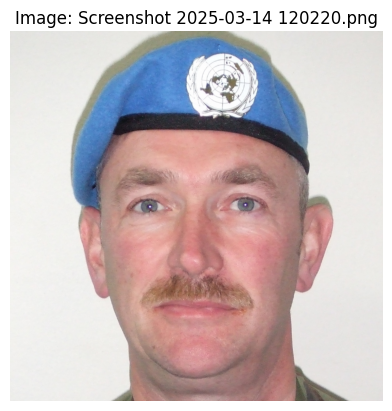

Prediction Score: 0.9935567
Prediction: REAL

--- Predicting with RESNET Model ---
Model loading time: 1.7081 seconds
Prediction time: 0.8328 seconds
Total latency: 2.5409 seconds


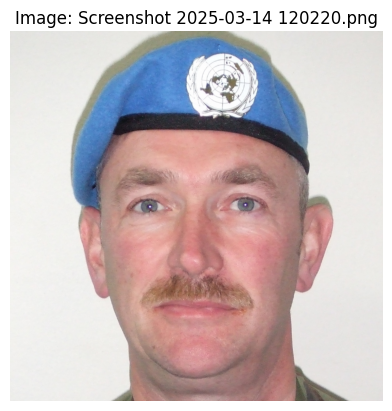

Prediction Score: 0.4766382
Prediction: FAKE

--- Predicting with MOBILENET Model ---
Model loading time: 0.6605 seconds
Prediction time: 0.3668 seconds
Total latency: 1.0273 seconds


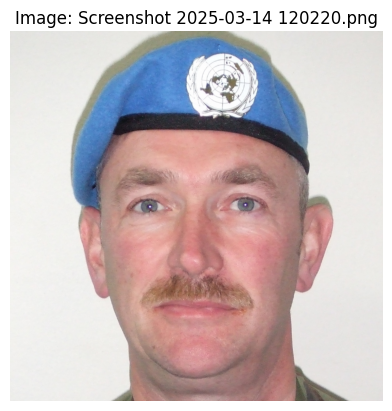

Prediction Score: 0.5127254
Prediction: REAL

--- Predicting with VGG16 Model ---
Model loading time: 0.4479 seconds
Prediction time: 0.2383 seconds
Total latency: 0.6862 seconds


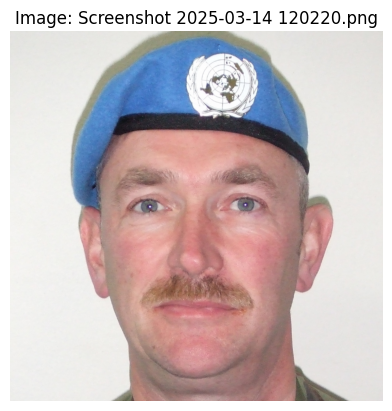

Prediction Score: 0.47420266
Prediction: FAKE

--- Predicting with LFAT Model ---
Model loading time: 1.9896 seconds
Prediction time: 0.9303 seconds
Total latency: 2.9199 seconds


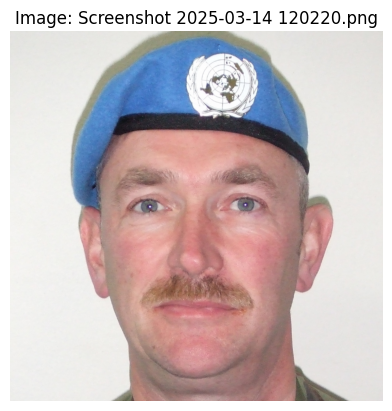

Prediction Score: 0.9983903
Prediction: REAL

--- Model Latency Comparison ---
Model      Load (s)   Predict (s)  Total (s)  Prediction   Confidence
----------------------------------------------------------------------
cnn        0.3180     0.0948       0.4128     REAL         0.9936    
resnet     1.7081     0.8328       2.5409     FAKE         0.4766    
mobilenet  0.6605     0.3668       1.0273     REAL         0.5127    
vgg16      0.4479     0.2383       0.6862     FAKE         0.4742    
lfat       1.9896     0.9303       2.9199     REAL         0.9984    


In [48]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import time  # Import time module for latency measurement
from tensorflow.keras import layers, models, optimizers # Import layers and models for custom layers
from tensorflow.keras.applications import MobileNetV2 # Import MobileNetV2 for the base model
from tensorflow.keras.utils import CustomObjectScope # Import CustomObjectScope

# --- USER-ADJUSTABLE PARAMETERS (Ensure these match your training setup) ---
# Default IMAGE_SIZE, can be overridden per model
DEFAULT_IMAGE_SIZE = (256, 256)

# Model-specific IMAGE_SIZE overrides
MODEL_IMAGE_SIZES = {
    'lfat': (224, 224),
    # Add other model-specific sizes here if needed
}

# --- MODEL NAMES - Should match the names you used during training and saving ---
model_names = ['cnn', 'resnet', 'mobilenet', 'vgg16', 'lfat'] # Added 'lfat' to the list
dataset_name = 'combined'  # Or whichever dataset you trained on and want to test with

# --- Base directory where your models are saved ---
BASE_MODEL_DIR = 'd:/deepfake'  # <---  Set your base model directory here


# --- CUSTOM LAYERS DEFINITIONS (Copy from your training script) ---
def transformer_encoder(inputs, num_heads, key_dim, ffn_dim, num_layers):
    x = inputs
    for _ in range(num_layers):
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization()(x)
        ffn_output = layers.Dense(ffn_dim, activation='relu')(x)
        ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization()(x)
    return x


class FrequencyAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FrequencyAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        cnn_feature_shape, freq_map_shape = input_shape
        self.channel_attention = layers.Dense(cnn_feature_shape[-1], activation='sigmoid') # Learn channel weights

    def call(self, inputs):
        cnn_features, freq_map = inputs

        # Global Average Pooling on Frequency Map
        frequency_attention_vector = tf.keras.layers.GlobalAveragePooling2D()(freq_map) # Shape (B, 1, 1) or (B, 1)

        # Learnable Transformation (FC layer to get channel weights)
        attention_weights = self.channel_attention(frequency_attention_vector) # Output shape (B, C), C = num_channels of cnn_features

        # Channel-wise Multiplication - Reshape weights to be broadcastable
        attention_weights = tf.reshape(attention_weights, (-1, 1, 1, cnn_features.shape[-1])) # Shape (B, 1, 1, C)

        # Apply attention to CNN features
        attended_cnn_features = cnn_features * attention_weights # Broadcasting will handle channel-wise multiplication
        return attended_cnn_features

class FrequencyTransformLayer(tf.keras.layers.Layer):
    def __init__(self, resize_shape=(224, 224), **kwargs):
        super(FrequencyTransformLayer, self).__init__(**kwargs)
        self.resize_shape = resize_shape  # Resize the frequency map to this shape

    def call(self, inputs):
        # Convert RGB to grayscale
        gray_image = tf.image.rgb_to_grayscale(inputs)

        # Compute 2D Fourier Transform (FFT) using TensorFlow
        fft = tf.signal.fft2d(tf.cast(gray_image, tf.complex64))

        # Calculate the Magnitude Spectrum
        magnitude_spectrum = tf.math.log1p(tf.abs(fft))

        # Resize the magnitude spectrum to match the CNN feature map size
        magnitude_spectrum_resized = tf.image.resize(
            magnitude_spectrum,
            self.resize_shape,
            method='bilinear'  # Bilinear interpolation
        )

        return magnitude_spectrum_resized


# Load and preprocess the image
def load_and_preprocess_image(img_path, target_size): # Modified to accept target_size
    try:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        return img_array
    except FileNotFoundError:
        print(f"Error: Image file not found at {img_path}")
        return None # Return None to indicate failure
    except Exception as e:
        print(f"Error loading or preprocessing image: {e}")
        return None # Return None to indicate failure


# Make predictions - MODIFIED to include latency measurements
def make_single_image_prediction(img_path, model_path, model_name):
    print(f"\n--- Predicting with {model_name.upper()} Model ---")

    # Determine the target image size for the current model
    target_image_size = MODEL_IMAGE_SIZES.get(model_name, DEFAULT_IMAGE_SIZE)

    try:
        # Measure model loading time
        load_start = time.time()
        # Load model with custom object scope
        with CustomObjectScope({'FrequencyTransformLayer': FrequencyTransformLayer, 'FrequencyAttentionLayer': FrequencyAttentionLayer, 'transformer_encoder': transformer_encoder}): # Added transformer_encoder as well just in case
            model = tf.keras.models.load_model(model_path)
        load_end = time.time()
        load_time = load_end - load_start
        print(f"Model loading time: {load_time:.4f} seconds")
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}. Skipping {model_name.upper()}.")
        return None # Return None if model loading fails
    except Exception as e:
        print(f"Error loading model {model_name.upper()}: {e}")
        return None # Return None if model loading fails


    # Load and preprocess the image with the correct target size
    img_array = load_and_preprocess_image(img_path, target_image_size) # Pass target_image_size
    if img_array is None: # Check if image loading/preprocessing failed
        return None # Return None if image preprocessing failed


    preprocess_start = time.time()
    preprocess_end = time.time() # Preprocessing already done in load_and_preprocess_image
    preprocess_time = preprocess_end - preprocess_start # Time spent inside load_and_preprocess_image is accounted there. This is negligible now.


    # Make the prediction with timing
    predict_start = time.time()
    prediction = model.predict(img_array, verbose=0)  # Set verbose=0 to reduce output noise
    predict_end = time.time()
    predict_time = predict_end - predict_start
    print(f"Prediction time: {predict_time:.4f} seconds")

    # Calculate total latency
    total_time = load_time + preprocess_time + predict_time
    print(f"Total latency: {total_time:.4f} seconds")

    # Display the image
    try:
        img = image.load_img(img_path)
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.title(f"Image: {os.path.basename(img_path)}")  # Show image filename in title
        plt.show()
    except Exception as e:
        print(f"Error displaying image: {e}")


    # Interpret the result (assuming binary classification)
    print("Prediction Score:", prediction[0][0])  # Print the raw prediction score
    if prediction > 0.5:
        print("Prediction: REAL")
    else:
        print("Prediction: FAKE")

    # Return timing data for comparison
    return {
        "model": model_name,
        "load_time": load_time,
        "predict_time": predict_time,
        "total_time": total_time,
        "prediction": "REAL" if prediction > 0.5 else "FAKE",
        "confidence": float(prediction[0][0])
    }

# --- USER-ADJUSTABLE IMAGE PATH ---
img_path = r"C:\Users\rdars\OneDrive\Pictures\Screenshots\Screenshot 2025-03-14 120220.png"  # <--- CHANGE THIS PATH TO YOUR IMAGE

# --- Loop through models and make predictions ---
results = []
for model_name in model_names:
    # Construct model path
    if model_name == 'lfat':
        model_path = os.path.join(BASE_MODEL_DIR, 'lfat_model_tuned.h5') # Path for LFAT model # Changed to the saved tuned model name
    else:
        model_path = os.path.join(BASE_MODEL_DIR, f"{model_name}_{dataset_name}.h5")  # Construct model path for other models

    if not os.path.exists(model_path):
        print(f"Warning: Model file not found: {model_path}. Skipping {model_name.upper()}.")
        continue  # Skip to the next model if file not found

    result = make_single_image_prediction(img_path, model_path, model_name)
    if result: # Only append result if prediction was successful (not None)
        results.append(result)

# Compare model latencies and performance
if results: # Only print comparison if there are valid results
    print("\n--- Model Latency Comparison ---")
    print(f"{'Model':<10} {'Load (s)':<10} {'Predict (s)':<12} {'Total (s)':<10} {'Prediction':<12} {'Confidence':<10}")
    print("-" * 70)
    for result in results:
        print(f"{result['model']:<10} {result['load_time']:<10.4f} {result['predict_time']:<12.4f} {result['total_time']:<10.4f} {result['prediction']:<12} {result['confidence']:<10.4f}")
else:
    print("\nNo models were successfully evaluated.")